# Projeto MTR

0. Pegar o dataset de heart disease (e possivelmente de airbnb)
1. Manipular os dados para deixá-los prontos para treinamento por modelos de ML 
2. Pesquisar e escolher os modelos para serem testados (de preferência modelos que sabemos ter erros correlacionados)
3. Treinar modelos (tentar achar os melhores hiperparâmetros, usar validação cruzada de 5 ou 10 folds)
4. Construir assessores (treinados para tentar prever o erro dos modelos) (também tentar achar melhores hiperparâmetros):

    4.1. Um assessor para cada modelo (RandomForestRegressor ou algum outro)
    
    4.2. Um assessor multi-target para todos os modelos (RegressorChains (outputs relacionados) **e** Single Target Method (outputs independentes))
    
    4.3. Um assessor para cada "família" ou grupo de modelos de ML com erros correlacionados (RegressorChains)

5. Coletar resultados e tirar conclusões para apresentar

## Imports e funções

In [1]:
from utils import *

In [45]:
from sklearn.model_selection import GridSearchCV
import json
from torch import save, load

# Dataset

**Attribute Information:**

- 1. age       
- 2. sex       
- 3. chest pain type  (4 values)       
- 4. resting blood pressure  
- 5. serum cholestoral in mg/dl      
- 6. fasting blood sugar > 120 mg/dl       
- 7. resting electrocardiographic results  (values 0,1,2)
- 8. maximum heart rate achieved  
- 9. exercise induced angina    
- 10. oldpeak = ST depression induced by exercise relative to rest   
- 11. the slope of the peak exercise ST segment     
- 12. number of major vessels (0-3) colored by flourosopy        
- 13.  thal: 3 = normal; 6 = fixed defect; 7 = reversable defect

**Attributes types:**

Real: 1,4,5,8,10,12

Ordered:11,

Binary: 2,6,9

Nominal:7,3,13

**Variable to be predicted:**

Absence (1) or presence (2) of heart disease

In [3]:
seed = 60412887 #randint(0, 4294967295)
print(seed)

60412887


In [4]:
cols = ['age', 'sex', 'chest_pain', 'blood_pressure', 
        'cholestoral', 'blood_sugar', 'eletro_results',
        'max_heart_rate', 'exer_angina', 'oldpeak',
        'slope_peak', 'major_vessels', 'thal']

df = pd.read_csv('data/heart/heart.dat', names=cols+['target'], sep=' ')

df['target'] = df['target'].apply(lambda x: 1 if x==2 else 0)

print(f'Nº de instâncias: {len(df)}')
df.head()

Nº de instâncias: 270


,age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,eletro_results,max_heart_rate,exer_angina,oldpeak,slope_peak,major_vessels,thal,target
0,70.0,1.0,4.0,130.0,322.0,0.0,2.0,109.0,0.0,2.4,2.0,3.0,3.0,1
1,67.0,0.0,3.0,115.0,564.0,0.0,2.0,160.0,0.0,1.6,2.0,0.0,7.0,0
2,57.0,1.0,2.0,124.0,261.0,0.0,0.0,141.0,0.0,0.3,1.0,0.0,7.0,1
3,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0,0
4,74.0,0.0,2.0,120.0,269.0,0.0,2.0,121.0,1.0,0.2,1.0,1.0,3.0,0


<Axes: >

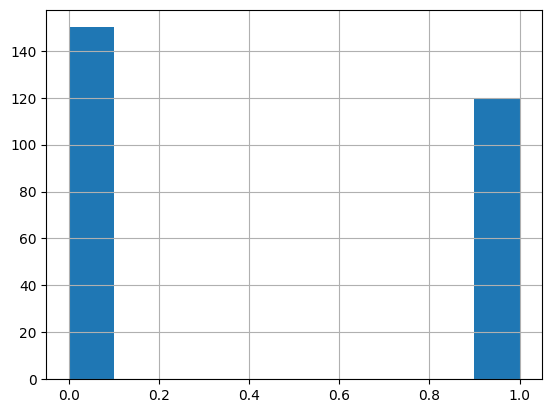

In [5]:
df['target'].hist()

<Axes: >

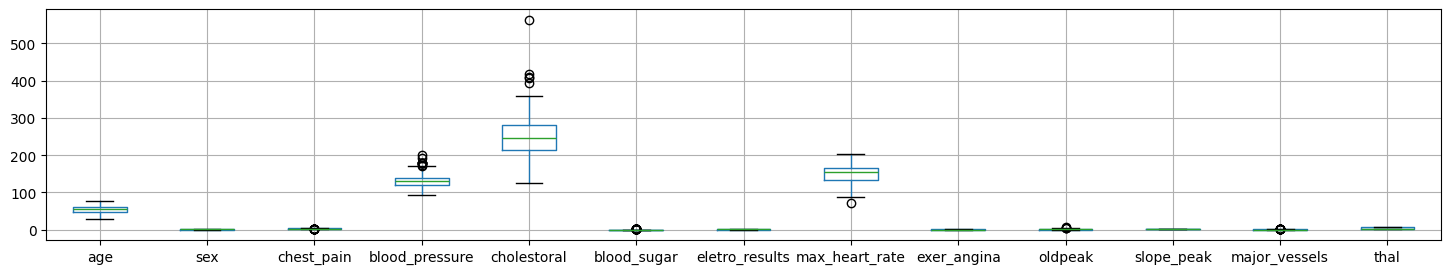

In [6]:
plt.figure(figsize=(18,3))
df[cols].boxplot()

<Axes: >

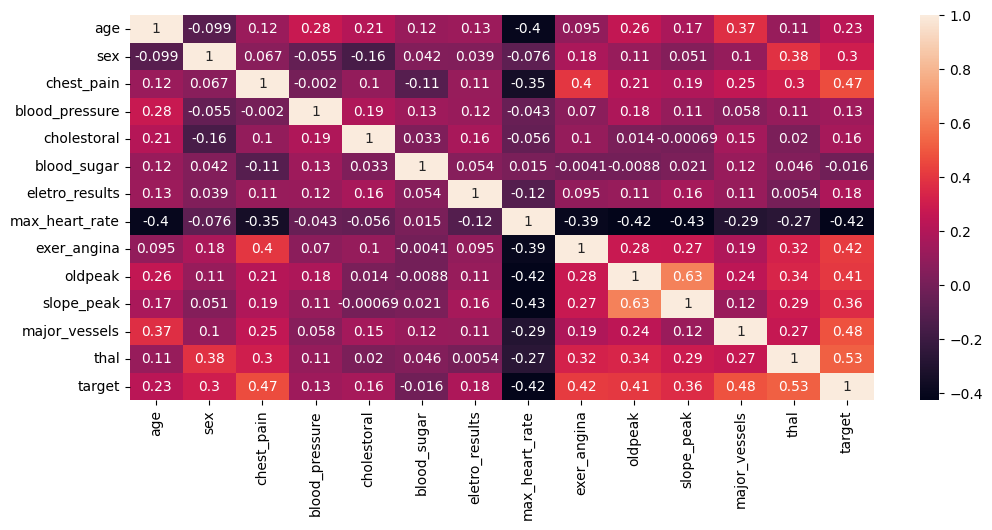

In [7]:
plt.figure(figsize=(12,5))
sns.heatmap(df.corr('spearman'), annot=True)

In [8]:
df.corr('spearman').dtypes

age               float64
sex               float64
chest_pain        float64
blood_pressure    float64
cholestoral       float64
blood_sugar       float64
eletro_results    float64
max_heart_rate    float64
exer_angina       float64
oldpeak           float64
slope_peak        float64
major_vessels     float64
thal              float64
target            float64
dtype: object

correlação regular entre:
- target e [chest_pain, max_heart_rate, exer_angina, oldpeak, major_vessels, thal]
- chest_pain e exer_angina
- max_heart_rate e [age, oldpeak, slope_peak]
- oldpeak e slope_peak

In [9]:
# 1/3 | 1/3 | 1/3
BASE_ASSESSOR_SPLIT = 0.3
BASE_TEST_SIZE = 0.5

temp = df[df.target==1]
train_pos, test_pos = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

temp = df[df.target==0]
train_neg, test_neg = train_test_split(temp, test_size=BASE_ASSESSOR_SPLIT, shuffle=True, random_state=seed)

Xb_train, Xb_test, yb_train, yb_test = train_test_split(pd.concat([train_pos[cols], train_neg[cols]], ignore_index=True), # X
                                                            pd.concat([train_pos['target'], train_neg['target']], ignore_index=True), # y
                                                            test_size=BASE_TEST_SIZE, shuffle=True, random_state=seed)

In [10]:
scaler = StandardScaler()

Xb_train_norm = scaler.fit_transform(Xb_train, yb_train)
Xb_test_norm = scaler.transform(Xb_test)

# se eu fosse normalizar os dados de teste do assessor, eu usaria o mesmo scaler?

In [11]:
Xa_test = pd.concat([test_pos[cols], test_neg[cols]], ignore_index=True)
ya_test = pd.concat([test_pos['target'], test_neg['target']], ignore_index=True)
Xa_test_norm = scaler.transform(Xa_test)

# Base Models

In [12]:
NUM_TRIALS = 25
performs = {}
pred_hits = pd.DataFrame()
models = []

In [13]:
def register_performance(train_set:list|tuple, test_set:list|tuple, model, model_name:str, pdict:dict=performs):
    assert (len(train_set)==2) & (len(test_set)==2)

    # train_set
    pred = model.predict(train_set[0])

    #try:
    #    pred_proba = model.predict_proba(train_set[0])[:, 1]
    #    pred_proba = [1-max(prob) for prob in pred_proba]
    #except AttributeError:
    #    pred_proba = model.decision_function(train_set[0])
    #    check = False
    #else:
    #    check = True

    pred_proba = model.predict_proba(train_set[0])
    minprob = [1-max(prob) for prob in pred_proba]

    metrics = compute_performance_metrics(train_set[1], pred, pred_proba[:,1])

    print('[Training]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name] = {'train': {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                   'recall':metrics[1],
                                   'precision':metrics[2], 'f1':metrics[3],
                                   'auroc':metrics[4], 'aupr':metrics[5]}}
    # test_set
    pred = model.predict(test_set[0])

    #if(check):
    pred_proba = model.predict_proba(test_set[0])
    minprob = [1-max(prob) for prob in pred_proba]
    #else:
    #    pred_proba = model.decision_function(test_set[0])

    metrics = compute_performance_metrics(test_set[1], pred, pred_proba[:,1])

    print('\n[Testing]')
    print_metrics_summary(metrics[0], metrics[1], metrics[2], metrics[3], metrics[4], metrics[5])
    print('{metric:<18}{value:.4f}'.format(metric="1-maxProb média:", value=np.mean(minprob)))
    print('{metric:<18}{value:.4f}'.format(metric='1-maxProb dp:', value=np.std(minprob)))
    pdict[model_name]['test'] = {'1-maxprob':minprob, 'accuracy':metrics[0], 
                                 'recall':metrics[1],
                                 'precision':metrics[2], 'f1':metrics[3],
                                 'auroc':metrics[4], 'aupr':metrics[5]}

### Decision Tree

In [14]:
#dtree = DecisionTreeClassifier(random_state=seed)#.fit(Xb_train, yb_train)

dt_params = {'max_depth':[None,10,20,30], 
             'criterion':['gini','entropy','log_loss'],
             'min_samples_split':[2,5,10,20,40,60], 
             'min_samples_leaf':[1,2,10,30]}

g_search = GridSearchCV(DecisionTreeClassifier(random_state=seed), dt_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
dtree = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 60}


In [15]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), dtree, 'dtree')

[Training]

Accuracy:         0.7979
Recall:           0.8250
Precision:        0.7333
F1:               0.7765
AUROC:            0.8014
AUPR:             0.6795
1-maxProb média:  0.2021
1-maxProb dp:     0.0618

[Testing]

Accuracy:         0.7474
Recall:           0.7045
Precision:        0.7381
F1:               0.7209
AUROC:            0.7444
AUPR:             0.6569
1-maxProb média:  0.1976
1-maxProb dp:     0.0615


In [16]:
pred_hits['dtree'] = dtree.predict(Xb_test) == yb_test
pred_hits.head()

,dtree
115,False
131,True
12,False
40,True
51,True


In [17]:
models.append(dtree)

### Stochastic Gradient Descent
(SGD)

In [18]:
#sgd = SGDClassifier(random_state=seed, loss='log_loss', n_jobs=-1).fit(Xb_train_norm, yb_train)

sgd_params = {
    'loss': ['log_loss', 'modified_huber'],
    'penalty': ['l2', 'l1', 'elasticnet'],
    'alpha': [1e-4, 1e-3, 1e-2]
}

g_search = GridSearchCV(SGDClassifier(random_state=seed), sgd_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
sgd = g_search.best_estimator_

{'alpha': 0.001, 'loss': 'modified_huber', 'penalty': 'l2'}


In [19]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), sgd, 'sgd')
pred_hits['sgd'] = sgd.predict(Xb_test_norm) == yb_test
models.append(sgd)

[Training]

Accuracy:         0.8511
Recall:           0.8250
Precision:        0.8250
F1:               0.8250
AUROC:            0.8662
AUPR:             0.7826
1-maxProb média:  0.0067
1-maxProb dp:     0.0456

[Testing]

Accuracy:         0.8000
Recall:           0.6818
Precision:        0.8571
F1:               0.7595
AUROC:            0.7986
AUPR:             0.7490
1-maxProb média:  0.0031
1-maxProb dp:     0.0301


### Logistic Regression

In [20]:
lr = LogisticRegression(random_state=seed, n_jobs=-1).fit(Xb_train_norm, yb_train)

lr_params = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'liblinear']
}

g_search = GridSearchCV(LogisticRegression(random_state=seed), lr_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
lr = g_search.best_estimator_

{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}


In [21]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), lr, 'lr')
pred_hits['lr'] = lr.predict(Xb_test_norm) == yb_test
models.append(lr)

[Training]

Accuracy:         0.8830
Recall:           0.8750
Precision:        0.8537
F1:               0.8642
AUROC:            0.9509
AUPR:             0.9388
1-maxProb média:  0.3741
1-maxProb dp:     0.0711

[Testing]

Accuracy:         0.8211
Recall:           0.7500
Precision:        0.8462
F1:               0.7952
AUROC:            0.9184
AUPR:             0.9085
1-maxProb média:  0.3609
1-maxProb dp:     0.0711


### K-Nearest Neighbors

(KNN)

In [22]:
#knn = KNeighborsClassifier(n_jobs=-1).fit(Xb_train_norm, yb_train)

knn_params = {
    'n_neighbors': list(range(3,21)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

g_search = GridSearchCV(KNeighborsClassifier(), knn_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
knn = g_search.best_estimator_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}


In [23]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), knn, 'knn')
pred_hits['knn'] = knn.predict(Xb_test_norm) == yb_test
models.append(knn)

[Training]

Accuracy:         0.9149
Recall:           0.8500
Precision:        0.9444
F1:               0.8947
AUROC:            0.9697
AUPR:             0.9538
1-maxProb média:  0.1213
1-maxProb dp:     0.1436

[Testing]

Accuracy:         0.8000
Recall:           0.6591
Precision:        0.8788
F1:               0.7532
AUROC:            0.8968
AUPR:             0.8617
1-maxProb média:  0.1411
1-maxProb dp:     0.1559


### Support Vector Machine - Linear
(SVM)

In [24]:
#svm_linear = SVC(kernel='linear', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_linear_params = {
    'C': [0.1, 1, 10]
}

g_search = GridSearchCV(SVC(kernel='linear', probability=True, random_state=seed), svm_linear_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_linear = g_search.best_estimator_

{'C': 0.1}


In [25]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_linear , 'svm_linear')
pred_hits['svm_linear'] = svm_linear.predict(Xb_test_norm) == yb_test
models.append(svm_linear)

[Training]

Accuracy:         0.9149
Recall:           0.8750
Precision:        0.9211
F1:               0.8974
AUROC:            0.9630
AUPR:             0.9444
1-maxProb média:  0.1702
1-maxProb dp:     0.1280

[Testing]

Accuracy:         0.8421
Recall:           0.7727
Precision:        0.8718
F1:               0.8193
AUROC:            0.9234
AUPR:             0.9108
1-maxProb média:  0.1469
1-maxProb dp:     0.1313


### Support Vector Machine - Polynomial
(SVM)

In [26]:
#svm_poly = SVC(kernel='poly', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_poly_params = {
    'C': [0.1, 1, 10],
    'degree': [2, 3, 4],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='poly', probability=True, random_state=seed), svm_poly_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_poly = g_search.best_estimator_

{'C': 1, 'degree': 3, 'gamma': 'scale'}


In [27]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_poly, 'svm_poly')
pred_hits['svm_poly'] = svm_poly.predict(Xb_test_norm) == yb_test
models.append(svm_poly)

[Training]

Accuracy:         0.9574
Recall:           0.9000
Precision:        1.0000
F1:               0.9474
AUROC:            0.9986
AUPR:             0.9981
1-maxProb média:  0.0932
1-maxProb dp:     0.1111

[Testing]

Accuracy:         0.8526
Recall:           0.7500
Precision:        0.9167
F1:               0.8250
AUROC:            0.8801
AUPR:             0.8544
1-maxProb média:  0.1042
1-maxProb dp:     0.1226


### Support Vector Machine - RBF
(SVM)

In [28]:
#svm_rbf = SVC(kernel='rbf', probability=True, random_state=seed).fit(Xb_train_norm, yb_train)

svm_rbf_params = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto']
}

g_search = GridSearchCV(SVC(kernel='rbf', probability=True, random_state=seed), svm_rbf_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
svm_rbf = g_search.best_estimator_

{'C': 1, 'gamma': 'scale'}


In [29]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), svm_rbf, 'svm_rbf')
pred_hits['svm_rbf'] = svm_rbf.predict(Xb_test_norm) == yb_test
models.append(svm_rbf)

[Training]

Accuracy:         0.9468
Recall:           0.9000
Precision:        0.9730
F1:               0.9351
AUROC:            0.9931
AUPR:             0.9905
1-maxProb média:  0.0934
1-maxProb dp:     0.0960

[Testing]

Accuracy:         0.8105
Recall:           0.6364
Precision:        0.9333
F1:               0.7568
AUROC:            0.9135
AUPR:             0.8953
1-maxProb média:  0.1644
1-maxProb dp:     0.1574


### Multi-Layer Perceptron
(MLP)

In [30]:
#mlp = MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed).fit(Xb_train_norm, yb_train)

mlp_params = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001]
}

g_search = GridSearchCV(MLPClassifier(max_iter=1000, n_iter_no_change=20, random_state=seed), mlp_params, n_jobs=-1, cv=5).fit(Xb_train_norm, yb_train)
print(g_search.best_params_)
mlp = g_search.best_estimator_

{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'solver': 'adam'}


In [31]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), mlp, 'mlp')
pred_hits['mlp'] = mlp.predict(Xb_test_norm) == yb_test
models.append(mlp)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0175
1-maxProb dp:     0.0313

[Testing]

Accuracy:         0.8316
Recall:           0.7727
Precision:        0.8500
F1:               0.8095
AUROC:            0.8859
AUPR:             0.8760
1-maxProb média:  0.0349
1-maxProb dp:     0.0774


### Kolmogorov-Arnold Network
(KAN)

In [41]:
kan_cv = int(input('Rodar CV da KAN? (0-Não / 1-Sim): '))

In [51]:
'''dataset = {'train_input': Xb_train_norm,
           'train_label': yb_train,
           'test_input': Xb_test_norm,
           'test_label': yb_test}'''

#best_width = [13,5,5,2]

kan_params = {'width': [[13,2,2,2], [13,3,2], [13,20,2]],
              'grid': [3, 6, 8],
              'lr': [0.0001, 0.001, 0.01],
              'lamb': [0.005, 0.1]}

if(kan_cv):
    best_score = 0
    for w in kan_params['width']:
        for g in kan_params['grid']:
            for lr in kan_params['lr']:
                for l in kan_params['lamb']:
                    score = cross_val_score(KANClassifier(w, grid=g, lr=lr, lamb=l, random_state=seed, grid_eps=1, steps=15), X=Xb_train_norm, y=yb_train, cv=5, error_score=0).mean()
                    if(score > best_score):
                        best_score = score
                        best_width = w
                        best_grid = g
                        best_lr = lr
                        best_lamb = l
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15).fit(Xb_train_norm, yb_train)
    with open('kan_params/heart.json', 'w') as f:
        json.dump({'width': best_width, 'grid': best_grid, 'lr': best_lr, 'lamb': best_lamb}, f)
        #joblib.dump(kanet.state_dict(), 'kan_params/heart.pkl')
    save(kanet.state_dict(), 'kan_params/heart.pt')
else:
    with open('kan_params/heart.json', 'r') as f:
        kan_dict = json.load(f)
    best_width = kan_dict['width']
    best_grid = kan_dict['grid']
    best_lr = kan_dict['lr']
    best_lamb = kan_dict['lamb']
    
    kanet = KANClassifier(best_width, grid=best_grid, lr=best_lr, lamb=best_lamb, random_state=seed, grid_eps=1, steps=15)
    kanet.load_state_dict(load('kan_params/heart.pt', weights_only=True))

print('width: {},\ngrid: {},\nlr: {},\nlamb: {}'.format(best_width, best_grid, best_lr, best_lamb))

width: [[13, 0], [3, 0], [2, 0]],
grid: 8,
lr: 0.0001,
lamb: 0.005


In [52]:
register_performance((Xb_train_norm, yb_train), (Xb_test_norm, yb_test), kanet, 'kan')
pred_hits['kan'] = kanet.predict(Xb_test_norm) == yb_test
models.append(kanet)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0104
1-maxProb dp:     0.0272

[Testing]

Accuracy:         0.7789
Recall:           0.6136
Precision:        0.8710
F1:               0.7200
AUROC:            0.8409
AUPR:             0.8584
1-maxProb média:  0.0353
1-maxProb dp:     0.0849


### Random Forest

In [53]:
#rforest = RandomForestClassifier(random_state=seed, n_jobs=-1).fit(Xb_train, yb_train)

parameters = {'max_depth':[None,10,20,30], 
              'criterion':['gini','entropy','log_loss'],
              'min_samples_split':[2,5,10,20,40,60], 
              'min_samples_leaf':[1,2,10,30],
              'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(RandomForestClassifier(random_state=seed), parameters, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
rforest = g_search.best_estimator_

{'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}


In [54]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), rforest, 'rforest')
pred_hits['rforest'] = rforest.predict(Xb_test) == yb_test
models.append(rforest)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.1112
1-maxProb dp:     0.0923

[Testing]

Accuracy:         0.8316
Recall:           0.7273
Precision:        0.8889
F1:               0.8000
AUROC:            0.9191
AUPR:             0.8999
1-maxProb média:  0.2053
1-maxProb dp:     0.1423


### Gradient Boosting

In [55]:
#gb = GradientBoostingClassifier(random_state=seed).fit(Xb_train, yb_train)

gb_params = {'max_depth':[None,10,20,30], 
             'criterion':['friedman_mse', 'squared_error'],
             'min_samples_split':[2,5,10,20,40,60], 
             'learning_rate': [0.01, 0.05, 0.1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(GradientBoostingClassifier(random_state=seed), gb_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
gb = g_search.best_estimator_

{'criterion': 'friedman_mse', 'learning_rate': 0.1, 'max_depth': None, 'min_samples_split': 40, 'n_estimators': 150}


In [56]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), gb, 'gb')
pred_hits['gb'] = gb.predict(Xb_test) == yb_test
models.append(gb)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0084
1-maxProb dp:     0.0092

[Testing]

Accuracy:         0.8316
Recall:           0.7727
Precision:        0.8500
F1:               0.8095
AUROC:            0.8984
AUPR:             0.8790
1-maxProb média:  0.0522
1-maxProb dp:     0.0982


### AdaBoost

In [57]:
#adab = AdaBoostClassifier(random_state=seed).fit(Xb_train, yb_train)

adab_params = {'learning_rate': [0.01, 0.05, 0.1, 1],
             'n_estimators':[20,50,100,150]}

g_search = GridSearchCV(AdaBoostClassifier(random_state=seed), adab_params, n_jobs=-1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
adab = g_search.best_estimator_

{'learning_rate': 0.1, 'n_estimators': 150}


c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [58]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), adab, 'adab')
pred_hits['adab'] = adab.predict(Xb_test) == yb_test
models.append(adab)

[Training]

Accuracy:         0.9574
Recall:           0.9500
Precision:        0.9500
F1:               0.9500
AUROC:            0.9981
AUPR:             0.9976
1-maxProb média:  0.4255
1-maxProb dp:     0.0508

[Testing]

Accuracy:         0.8105
Recall:           0.6818
Precision:        0.8824
F1:               0.7692
AUROC:            0.8857
AUPR:             0.8305
1-maxProb média:  0.4237
1-maxProb dp:     0.0490


### XGBoost

In [59]:
#xgb = XGBClassifier(random_state=seed).fit(Xb_train, yb_train)

xgb_params = {
    'n_estimators': [20,50,100,150],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [None,5,10,20,30],
    'gamma': [None, 0.25, 0.5]
}

g_search = GridSearchCV(XGBClassifier(random_state=seed), xgb_params, n_jobs=1, cv=5).fit(Xb_train, yb_train)
print(g_search.best_params_)
xgb = g_search.best_estimator_

{'gamma': 0.25, 'learning_rate': 0.05, 'max_depth': None, 'n_estimators': 150}


In [60]:
register_performance((Xb_train, yb_train), (Xb_test, yb_test), xgb, 'xgb')
pred_hits['xgb'] = xgb.predict(Xb_test) == yb_test
models.append(xgb)

[Training]

Accuracy:         1.0000
Recall:           1.0000
Precision:        1.0000
F1:               1.0000
AUROC:            1.0000
AUPR:             1.0000
1-maxProb média:  0.0784
1-maxProb dp:     0.0837

[Testing]

Accuracy:         0.8211
Recall:           0.7500
Precision:        0.8462
F1:               0.7952
AUROC:            0.9033
AUPR:             0.8933
1-maxProb média:  0.0948
1-maxProb dp:     0.1139


## Análise de Correlações

In [61]:
groups = {}

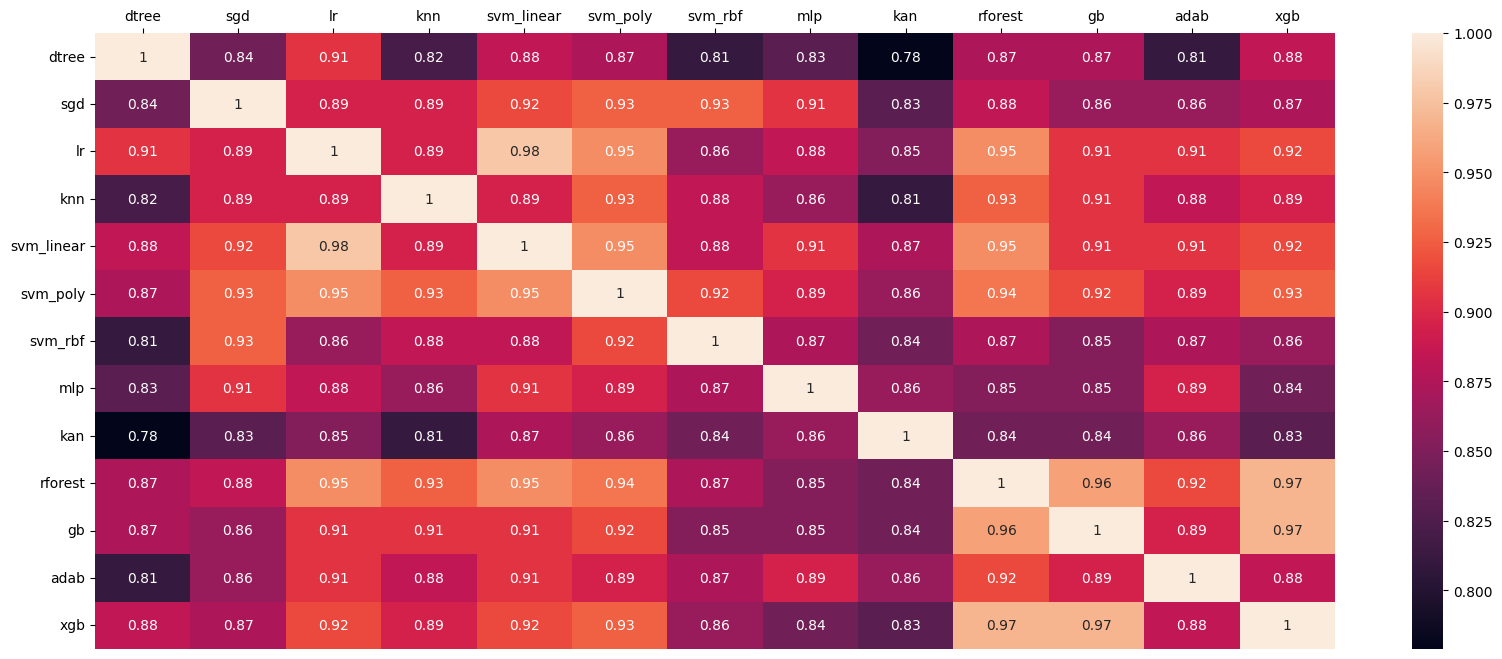

In [62]:
pred_corrls = pd.DataFrame(columns=pred_hits.columns, index=pred_hits.columns, dtype=float)

for m in pred_hits.columns:
    for n in pred_hits.columns:
        pred_corrls.at[m,n] = np.mean(pred_hits[m] == pred_hits[n])

plt.figure(figsize=(20,8))
hm = sns.heatmap(pred_corrls, annot=True)
hm.xaxis.tick_top()

In [63]:
corrls_values = pd.Series(pred_corrls.values.reshape((169,)))
corrls_values.describe()

count    169.000000
mean       0.895111
std        0.048888
min        0.778947
25%        0.863158
50%        0.894737
75%        0.915789
max        1.000000
dtype: float64

<Axes: >

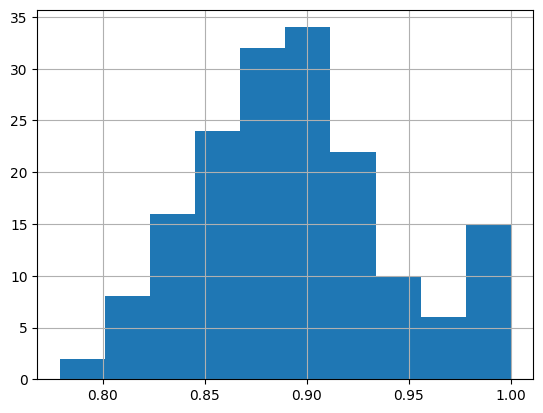

In [64]:
corrls_values.hist()

Se for pegar um grupo para analisar, tentar usar como a correlação mínima entre previsões o 3º quantil, o que daria por volta de  (no caso atual)

In [65]:
def group_search_help(df: pd.DataFrame, min_score: int, models: list | set = None, base_group: list = []):
    if models is None:
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']

    if len(base_group) == 0:
        base_group, models = models[:1], models[1:]

    output_groups = []

    for m in models:
        check = True
        for bg in base_group:
            corr = df.at[bg, m]
            if np.isnan(corr) or corr < min_score:
                check = False
                break
        if check:
            temp = models.copy()
            temp.remove(m)
            output_groups.append(
                group_search_help(df, min_score, temp, base_group + [m])
            )

    if len(output_groups) == 0:
        return base_group

    return output_groups

def group_search(df: pd.DataFrame, min_score: int, models: list = None):
    if models is None:
        models = ['dtree', 'sgd', 'lr', 'knn', 'svm_linear', 'svm_poly', 'svm_rbf', 'mlp',
                  'kan', 'rforest', 'gb', 'adab', 'xgb']

    # Corrige valores abaixo do min_score
    df = df.map(lambda x: np.nan if x < min_score else x)

    raw_groups = []
    for i in range(len(models)):
        raw_groups.append(group_search_help(df, min_score, models[i:]))

    return remove_subgroups(flatten_groups(raw_groups))
    
def flatten_groups(nested_list):
    flat_list = []

    def _flatten(item):
        if isinstance(item[0], list):
            for subitem in item:
                _flatten(subitem)
        else:
            flat_list.append(sorted(item))  # ordena para facilitar comparação de subconjuntos

    _flatten(nested_list)
    return flat_list

def remove_subgroups(groups:list):
    # Remove duplicatas (grupos com os mesmos elementos, em qualquer ordem)
    seen = set()
    unique_groups = []
    for g in groups:
        frozen = frozenset(g)
        if frozen not in seen:
            seen.add(frozen)
            unique_groups.append(g)

    # Agora removemos subconjuntos estritos
    filtered_groups = []
    for g in unique_groups:
        is_subset = False
        for other in unique_groups:
            if g != other and set(g).issubset(set(other)):
                is_subset = True
                break
        if not is_subset:
            filtered_groups.append(g)

    return filtered_groups

In [66]:
min_score = corrls_values.quantile(0.75)

print('Min_score:', min_score)

groups['true_assessor_train'] = group_search(pred_corrls, min_score)
groups['true_assessor_train']

Min_score: 0.9157894736842105


[['dtree'],
 ['sgd', 'svm_linear', 'svm_poly'],
 ['sgd', 'svm_poly', 'svm_rbf'],
 ['lr', 'rforest', 'svm_linear', 'svm_poly', 'xgb'],
 ['knn', 'rforest', 'svm_poly'],
 ['gb', 'rforest', 'svm_poly', 'xgb'],
 ['mlp'],
 ['kan'],
 ['adab', 'rforest']]

fazer com que todos os modelos do grupo tenham uma correlação acima do score mínimo entre todos eles? Ou fazer com que o próximo modelo encontrado do grupo tenha uma correlação acima do mínimo com o modelo mais recente?

(provavelmente o primeiro)

# Assessors

In [67]:
#def nmse(y_true, y_pred):
#    '''Normalized Mean Squared Error'''
#    #mean_squared = mse(y_true, y_pred)
#    sum1, sum2 = 0, 0
#    n = len(y_true)
#    y_mean = y_true.mean()
#    for i in range(n):
#        sum1 += ((y_pred[i] - y_true[i])**2)
#        sum2 += ((y_mean - y_true[i])**2)
#    return sum1 / sum2 #* mean_squared

def nmse(y_true, y_pred):
    mse_error = np.mean((y_true - y_pred) ** 2)
    variance = np.var(y_true)
    if variance == 0:
        raise ValueError("A variância dos valores reais é zero; não é possível normalizar.")    
    return mse_error / variance

def nmse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)    
    error = {}
    for c in y_true.columns:
        error[c] = nmse(y_true[c], y_pred[c])
    return error

def mse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = ((y_true[c] - y_pred[c])**2).mean()
    return error

def rmse_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = (((y_true[c] - y_pred[c])**2).mean())**0.5
    return error

def mae_models(y_true, y_pred):
    y_pred = pd.DataFrame(y_pred, columns=y_true.columns)
    error = {}
    for c in y_true.columns:
        error[c] = (abs(y_true[c] - y_pred[c])).mean()
    return error

In [68]:
df_assessor = pd.concat([Xb_test, yb_test], axis=1)

#y_pred = dtree.predict(Xa_test)

model_names = list(performs.keys())
#pred_hits = {}
df_assessor[model_names] = np.NaN

for i in range(len(models)):
    
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xb_test)
    else:
        y_pred = models[i].predict_proba(Xb_test_norm)

    #pred_hits[model_names[i]] = np.argmax(y_pred, axis=1) == yb_test
    # np.arange vai retornar os índices das duplas de probabilidades.
    # yb_test vai epecificar o índice (classe) da probabilidade da classe correta
    # dentro de cada dupla de probabilidades.
    df_assessor.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), yb_test]

df_assessor.head()

,age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,eletro_results,max_heart_rate,exer_angina,oldpeak,...,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
115,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,...,1.0,0.922145,0.962813,0.973425,0.999623,0.987163,0.85,0.999621,0.665205,0.962335
131,61.0,1.0,3.0,150.0,243.0,1.0,0.0,137.0,1.0,1.0,...,0.4,0.227860,0.138998,0.232454,0.047386,0.002060,0.30,0.033610,0.459122,0.513467
12,58.0,0.0,2.0,136.0,319.0,1.0,2.0,152.0,0.0,0.0,...,1.0,0.893359,0.972718,0.928617,0.999808,0.756189,0.75,0.998479,0.572783,0.909080
40,60.0,1.0,4.0,145.0,282.0,0.0,2.0,142.0,1.0,2.8,...,0.0,0.027827,0.012555,0.008787,0.000004,0.000053,0.00,0.000378,0.358806,0.017478
51,54.0,1.0,4.0,110.0,239.0,0.0,0.0,126.0,1.0,2.8,...,0.0,0.093144,0.034455,0.035390,0.004420,0.001035,0.10,0.000414,0.395542,0.020938


In [69]:
Xa_train = df_assessor.loc[:,['age', 'sex', 'chest_pain', 'blood_pressure', 'cholestoral',
       'blood_sugar', 'eletro_results', 'max_heart_rate', 'exer_angina',
       'oldpeak', 'slope_peak', 'major_vessels', 'thal']]

ya_train_tgt = df_assessor['target']
ya_train = df_assessor.loc[:,model_names]

In [70]:
Xa_train.head()

,age,sex,chest_pain,blood_pressure,cholestoral,blood_sugar,eletro_results,max_heart_rate,exer_angina,oldpeak,slope_peak,major_vessels,thal
115,64.0,1.0,4.0,128.0,263.0,0.0,0.0,105.0,1.0,0.2,2.0,1.0,7.0
131,61.0,1.0,3.0,150.0,243.0,1.0,0.0,137.0,1.0,1.0,2.0,0.0,3.0
12,58.0,0.0,2.0,136.0,319.0,1.0,2.0,152.0,0.0,0.0,1.0,2.0,3.0
40,60.0,1.0,4.0,145.0,282.0,0.0,2.0,142.0,1.0,2.8,2.0,2.0,7.0
51,54.0,1.0,4.0,110.0,239.0,0.0,0.0,126.0,1.0,2.8,2.0,1.0,7.0


In [71]:
ya_train.head()

,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
115,0.733333,1.0,0.682079,1.0,0.922145,0.962813,0.973425,0.999623,0.987163,0.85,0.999621,0.665205,0.962335
131,0.142857,0.0,0.447787,0.4,0.227860,0.138998,0.232454,0.047386,0.002060,0.30,0.033610,0.459122,0.513467
12,0.857143,1.0,0.657508,1.0,0.893359,0.972718,0.928617,0.999808,0.756189,0.75,0.998479,0.572783,0.909080
40,0.266667,0.0,0.250467,0.0,0.027827,0.012555,0.008787,0.000004,0.000053,0.00,0.000378,0.358806,0.017478
51,0.266667,0.0,0.315945,0.0,0.093144,0.034455,0.035390,0.004420,0.001035,0.10,0.000414,0.395542,0.020938


In [72]:
ya_test = pd.DataFrame(ya_test)

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict_proba(Xa_test)
    else:
        y_pred = models[i].predict_proba(Xa_test_norm)
        
    ya_test.loc[:,model_names[i]] = 1 - y_pred[np.arange(len(y_pred)), ya_test['target']]

ya_test_tgt = ya_test['target']
ya_test = ya_test.drop(columns=['target'])

#### Análise de correlações

Conjunto de Treinamento:

O conjunto de teste dos modelos base já é o conjunto de treinamento dos assessores.

Conjunto de Teste:

In [73]:
pred_hits2 = {}

for i in range(len(models)):
    if(model_names[i] in ['dtree', 'rforest', 'gb', 'adab', 'xgb']):
        y_pred = models[i].predict(Xa_test)
    else:
        y_pred = models[i].predict(Xa_test_norm)
        
    pred_hits2[model_names[i]] = y_pred == ya_test_tgt

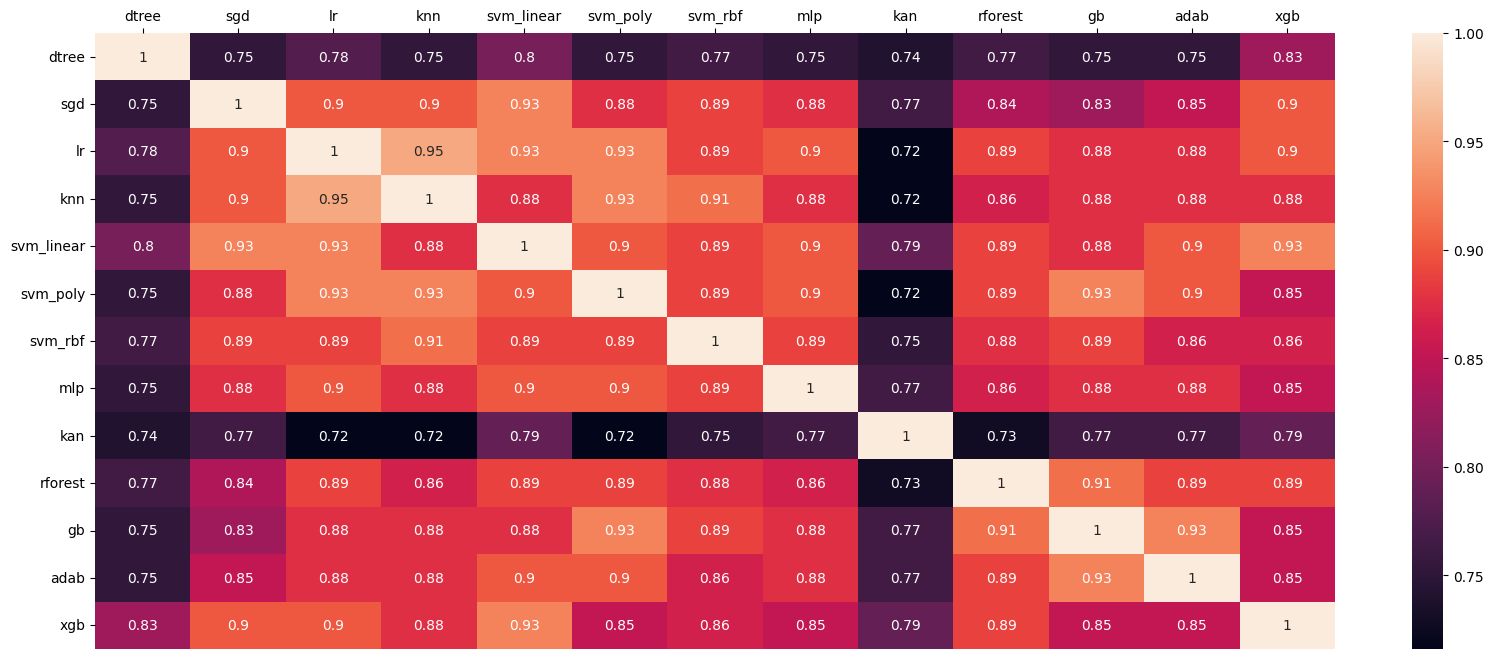

In [74]:
pred_corrls2 = pd.DataFrame(columns=model_names, index=model_names, dtype=float)

for m in model_names:
    for n in model_names:
        pred_corrls2.at[m,n] = np.mean(pred_hits2[m] == pred_hits2[n])

plt.figure(figsize=(20,8))
hm = sns.heatmap(pred_corrls2, annot=True)
hm.xaxis.tick_top()

In [75]:
corrls_values2 = pd.Series(pred_corrls2.values.reshape((169,)))
corrls_values2.describe()

count    169.000000
mean       0.861495
std        0.073316
min        0.716049
25%        0.802469
50%        0.876543
75%        0.901235
max        1.000000
dtype: float64

In [76]:
min_score2 = corrls_values2.quantile(0.75)

print('Min_score:', min_score2)

groups['true_assessor_test'] = group_search(pred_corrls2, min_score2)
groups['true_assessor_test']

Min_score: 0.9012345679012346


[['dtree'],
 ['knn', 'lr', 'sgd'],
 ['lr', 'sgd', 'svm_linear', 'xgb'],
 ['knn', 'lr', 'svm_poly'],
 ['lr', 'mlp', 'svm_linear', 'svm_poly'],
 ['knn', 'svm_rbf'],
 ['adab', 'svm_linear', 'svm_poly'],
 ['adab', 'gb', 'svm_poly'],
 ['kan'],
 ['gb', 'rforest']]

## Globais

### Regressor Chain
(RC)

In [77]:
regchain = RegressorChain(RandomForestRegressor(random_state=seed), verbose=True, random_state=seed, cv=5).fit(Xa_train, ya_train)

[Chain] .................. (1 of 13) Processing order 0, total=   0.1s
[Chain] .................. (2 of 13) Processing order 1, total=   0.1s
[Chain] .................. (3 of 13) Processing order 2, total=   0.1s
[Chain] .................. (4 of 13) Processing order 3, total=   0.1s
[Chain] .................. (5 of 13) Processing order 4, total=   0.1s
[Chain] .................. (6 of 13) Processing order 5, total=   0.1s
[Chain] .................. (7 of 13) Processing order 6, total=   0.1s
[Chain] .................. (8 of 13) Processing order 7, total=   0.1s
[Chain] .................. (9 of 13) Processing order 8, total=   0.1s
[Chain] ................. (10 of 13) Processing order 9, total=   0.1s
[Chain] ................ (11 of 13) Processing order 10, total=   0.1s
[Chain] ................ (12 of 13) Processing order 11, total=   0.1s
[Chain] ................ (13 of 13) Processing order 12, total=   0.1s


In [78]:
mse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
rmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
nmse_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)
mae_df = pd.DataFrame(columns=model_names, index=['regchain', 'multi-output', 'individual'], dtype=float)

In [79]:
ya_pred = regchain.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

mse_df.loc['regchain',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['regchain',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['regchain',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['regchain',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0829
RMSE: 0.2713
MAE: 0.2098


,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
regchain,0.07075,0.144675,0.00802,0.088693,0.063051,0.085074,0.076151,0.119054,0.155764,0.049132,0.121251,0.00383,0.091771
multi-output,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Análise das correlações

Melhorar esse cálculo de correlação para fazer melhor uso do 1-(probabilidade da classe correta)

Conjunto de Treinamento:

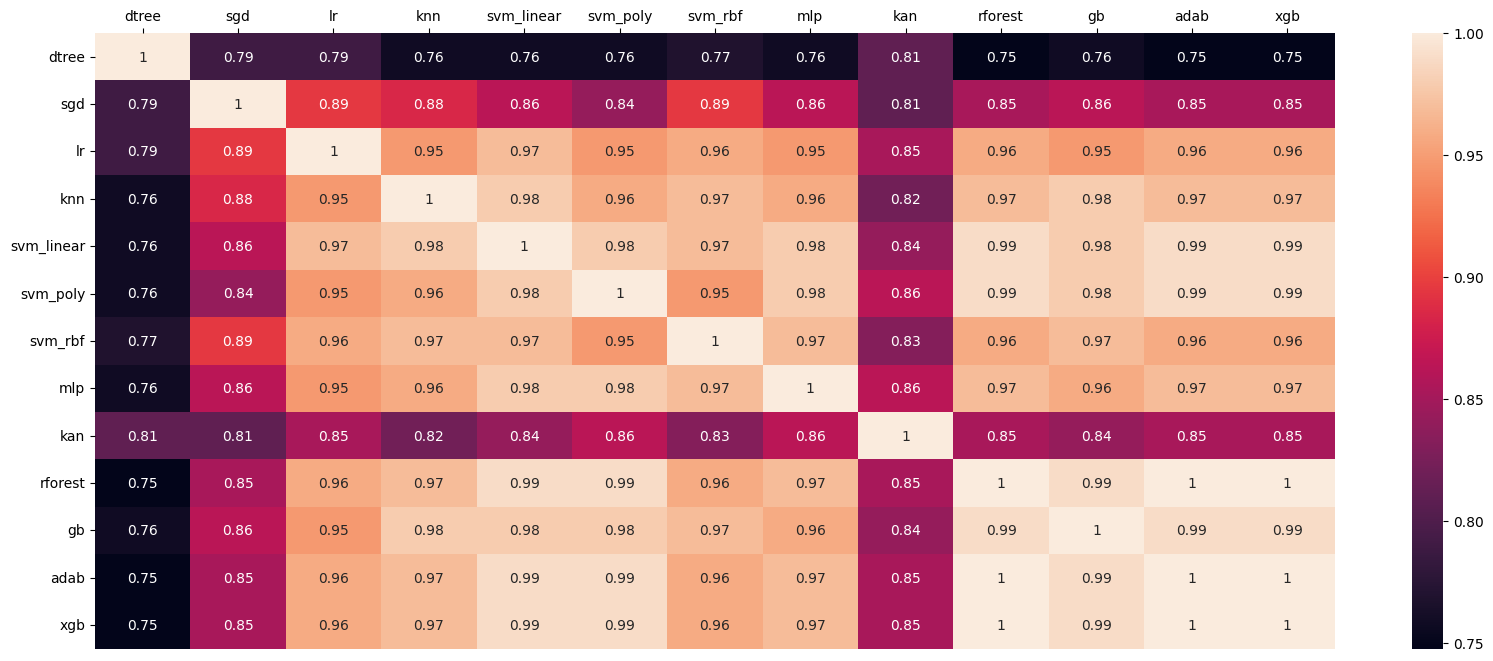

In [80]:
y_pred = pd.DataFrame(regchain.predict(Xa_train), columns=model_names, index=Xa_train.index)
# v Melhorar esse cálculo de correlação para fazer 
# v melhor uso do 1-(probabilidade da classe correta)
y_pred = y_pred.map(lambda x: 1 - round(x))

regchain_corrls = pd.DataFrame(columns=model_names, index=model_names, dtype=float)

for m in model_names:
    for n in model_names:
        regchain_corrls.at[m,n] = np.mean((y_pred[m]==ya_train_tgt)==(y_pred[n]==ya_train_tgt))

plt.figure(figsize=(20,8))
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()

In [81]:
regchain_corrls_values = pd.Series(regchain_corrls.values.reshape((169,)))
regchain_corrls_values.describe()

count    169.000000
mean       0.915540
std        0.081568
min        0.747368
25%        0.852632
50%        0.957895
75%        0.978947
max        1.000000
dtype: float64

In [82]:
min_score3 = regchain_corrls_values.quantile(0.75)

print('Min_score:', min_score3)

groups['regchain_assessor_train'] = group_search(regchain_corrls, min_score3)
groups['regchain_assessor_train']

Min_score: 0.9789473684210527


[['dtree'],
 ['sgd'],
 ['lr'],
 ['gb', 'knn', 'svm_linear'],
 ['mlp', 'svm_linear', 'svm_poly'],
 ['adab', 'gb', 'rforest', 'svm_linear', 'svm_poly', 'xgb'],
 ['svm_rbf'],
 ['kan']]

Conjunto de Teste:

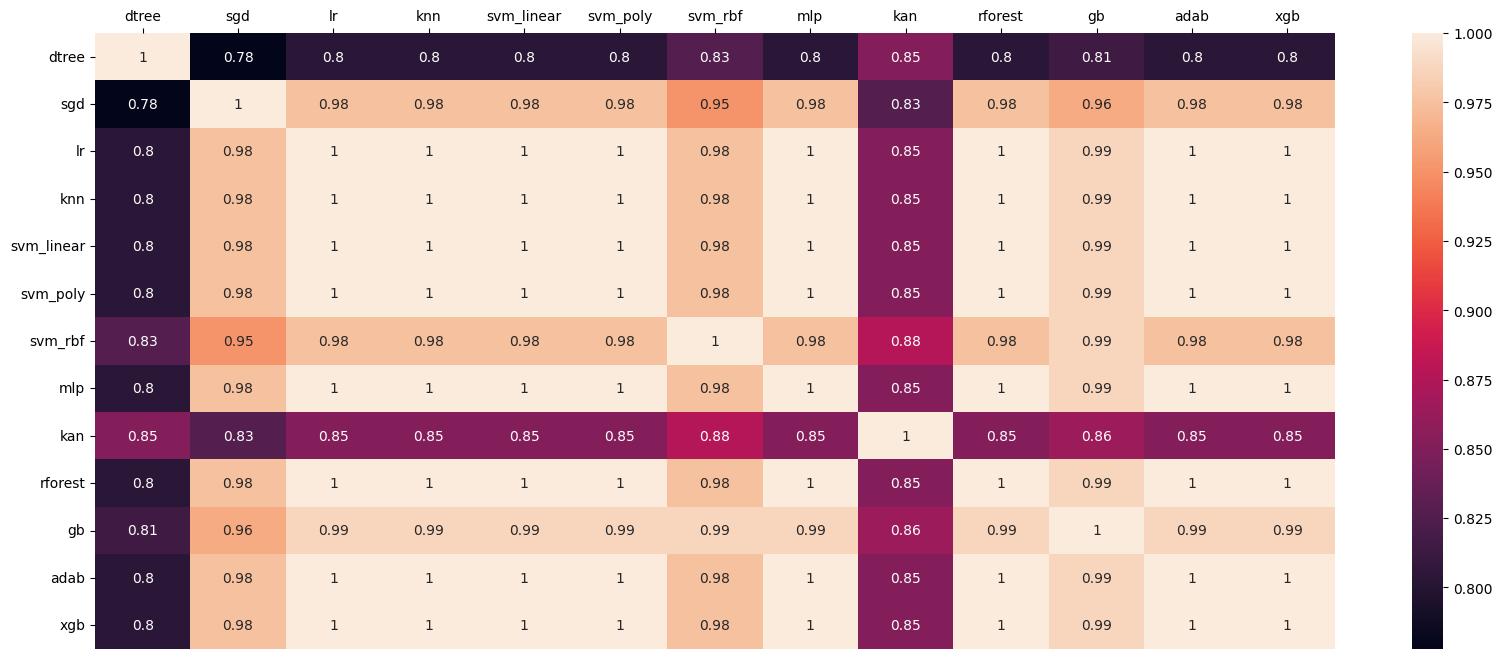

In [83]:
y_pred = pd.DataFrame(regchain.predict(Xa_test), columns=model_names, index=Xa_test.index)
# v Melhorar esse cálculo de correlação para fazer 
# v melhor uso do 1-(probabilidade da classe correta)
y_pred = y_pred.map(lambda x: 1 - round(x)) 

regchain_corrls = pd.DataFrame(columns=model_names, index=model_names, dtype=float)

for m in model_names:
    for n in model_names:
        regchain_corrls.at[m,n] = np.mean((y_pred[m]==ya_test_tgt)==(y_pred[n]==ya_test_tgt))

plt.figure(figsize=(20,8))
hm = sns.heatmap(regchain_corrls, annot=True)
hm.xaxis.tick_top()

In [84]:
regchain_corrls_values = pd.Series(regchain_corrls.values.reshape((169,)))
regchain_corrls_values.describe()

count    169.000000
mean       0.946526
std        0.074009
min        0.777778
25%        0.864198
50%        0.987654
75%        1.000000
max        1.000000
dtype: float64

In [85]:
min_score3 = regchain_corrls_values.quantile(0.75)

print('Min_score:', min_score3)

groups['regchain_assessor_test'] = group_search(regchain_corrls, min_score3)
groups['regchain_assessor_test']

Min_score: 1.0


[['dtree'],
 ['sgd'],
 ['adab', 'knn', 'lr', 'mlp', 'rforest', 'svm_linear', 'svm_poly', 'xgb'],
 ['svm_rbf'],
 ['kan'],
 ['gb']]

### Multi-Output Regressor 
(ST)

In [86]:
mor = MultiOutputRegressor(RandomForestRegressor(random_state=seed), n_jobs=-1).fit(Xa_train, ya_train)

In [87]:
ya_pred = mor.predict(Xa_test)

print(f'''MSE: {mse(ya_test, ya_pred):.4f}
RMSE: {rmse(ya_test, ya_pred):.4f}
MAE: {mae(ya_test, ya_pred):.4f}''')

#mse_models(ya_test, ya_pred)
mse_df.loc['multi-output',:] = mse_models(ya_test, ya_pred)
rmse_df.loc['multi-output',:] = rmse_models(ya_test, ya_pred)
nmse_df.loc['multi-output',:] = nmse_models(ya_test, ya_pred)
mae_df.loc['multi-output',:] = mae_models(ya_test, ya_pred)
mse_df

MSE: 0.0882
RMSE: 0.2791
MAE: 0.2145


,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
regchain,0.07075,0.144675,0.008020,0.088693,0.063051,0.085074,0.076151,0.119054,0.155764,0.049132,0.121251,0.003830,0.091771
multi-output,0.07075,0.149822,0.008231,0.085860,0.057809,0.081284,0.081516,0.139950,0.160672,0.056684,0.143984,0.003806,0.106339
individual,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Análise das correlações

Conjunto de Treinamento:

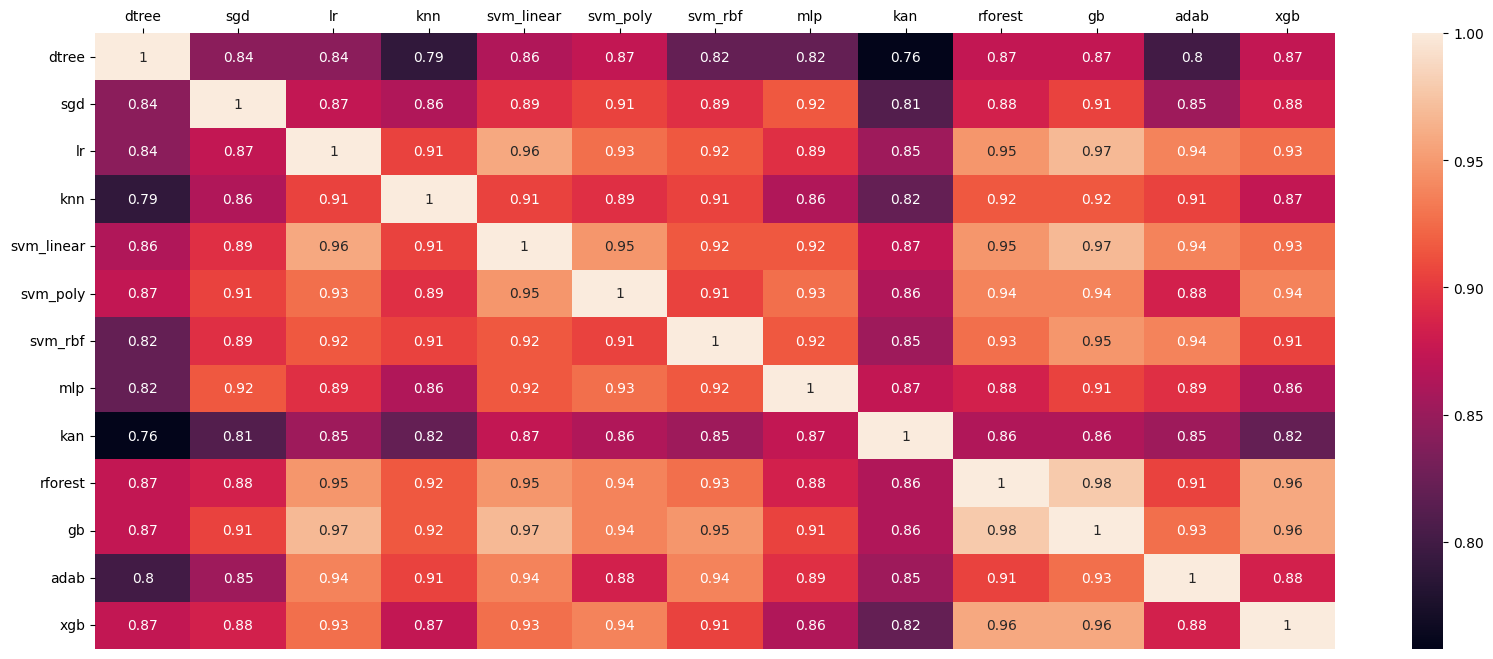

In [88]:
y_pred = pd.DataFrame(mor.predict(Xa_train), columns=model_names, index=Xa_train.index)
# v Melhorar esse cálculo de correlação para fazer 
# v melhor uso do 1-(probabilidade da classe correta)
y_pred = y_pred.map(lambda x: 1 - round(x)) 

mor_corrls = pd.DataFrame(columns=model_names, index=model_names, dtype=float)
size_preds = len(ya_test)

for m in model_names:
    for n in model_names:
        mor_corrls.at[m,n] = np.mean((y_pred[m]==ya_train_tgt)==(y_pred[n]==ya_train_tgt))

plt.figure(figsize=(20,8))
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()

In [89]:
mor_corrls_values = pd.Series(mor_corrls.values.reshape((169,)))
mor_corrls_values.describe()

count    169.000000
mean       0.901588
std        0.051314
min        0.757895
25%        0.873684
50%        0.905263
75%        0.936842
max        1.000000
dtype: float64

In [90]:
min_score4 = mor_corrls_values.quantile(0.75)

print('Min_score:', min_score4)

groups['mor_assessor_train'] = group_search(mor_corrls, min_score4)
groups['mor_assessor_train']

Min_score: 0.9368421052631579


[['dtree'],
 ['sgd'],
 ['gb', 'lr', 'rforest', 'svm_linear'],
 ['adab', 'lr', 'svm_linear'],
 ['knn'],
 ['gb', 'rforest', 'svm_linear', 'svm_poly'],
 ['gb', 'rforest', 'svm_poly', 'xgb'],
 ['gb', 'svm_rbf'],
 ['adab', 'svm_rbf'],
 ['mlp'],
 ['kan']]

Conjunto de Teste:

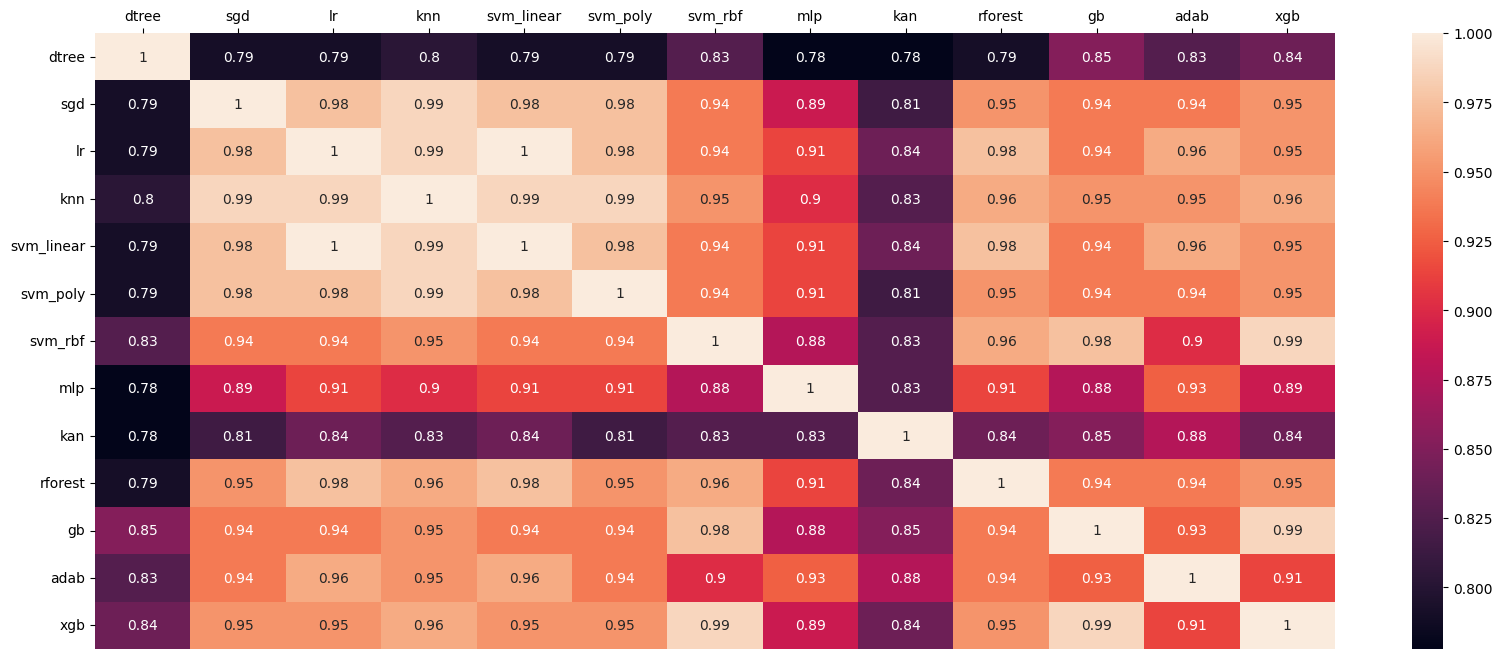

In [91]:
y_pred = pd.DataFrame(mor.predict(Xa_test), columns=model_names, index=Xa_test.index)
# v Melhorar esse cálculo de correlação para fazer 
# v melhor uso do 1-(probabilidade da classe correta)
y_pred = y_pred.map(lambda x: 1 - round(x)) 

mor_corrls = pd.DataFrame(columns=model_names, index=model_names, dtype=float)

for m in model_names:
    for n in model_names:
        mor_corrls.at[m,n] = np.mean((y_pred[m]==ya_test_tgt) == (y_pred[n]==ya_test_tgt))

plt.figure(figsize=(20,8))
hm = sns.heatmap(mor_corrls, annot=True)
hm.xaxis.tick_top()

In [92]:
mor_corrls_values = pd.Series(mor_corrls.values.reshape((169,)))
mor_corrls_values.describe()

count    169.000000
mean       0.916137
std        0.066849
min        0.777778
25%        0.851852
50%        0.938272
75%        0.975309
max        1.000000
dtype: float64

In [93]:
min_score4 = mor_corrls_values.quantile(0.75)

print('Min_score:', min_score4)

groups['mor_assessor_test'] = group_search(mor_corrls, min_score4)
groups['mor_assessor_test']

Min_score: 0.9753086419753086


[['dtree'],
 ['knn', 'lr', 'sgd', 'svm_linear', 'svm_poly'],
 ['lr', 'rforest', 'svm_linear'],
 ['gb', 'svm_rbf', 'xgb'],
 ['mlp'],
 ['kan'],
 ['adab']]

## Individuais

In [94]:
ind_assessors = {}
parameters['criterion'] = ['squared_error', 'poisson', 'friedman_mse']

for i in range(len(models)):
    g_search = GridSearchCV(RandomForestRegressor(random_state=seed), parameters, cv=5, n_jobs=-1)
    ind_assessors[model_names[i]] = g_search.fit(Xa_train, ya_train[model_names[i]]).best_estimator_
    print(f'[Assessor {i}] | Modelo Base: {model_names[i]} | Parâmetros: {g_search.best_params_}\nScore: {g_search.best_score_:.4f}\n')

c:\Users\pedro\pyenvs\mainpy\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


[Assessor 0] | Modelo Base: dtree | Parâmetros: {'criterion': 'poisson', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Score: 0.0138

[Assessor 1] | Modelo Base: sgd | Parâmetros: {'criterion': 'squared_error', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 60, 'n_estimators': 20}
Score: -0.0743

[Assessor 2] | Modelo Base: lr | Parâmetros: {'criterion': 'poisson', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 150}
Score: 0.0733

[Assessor 3] | Modelo Base: knn | Parâmetros: {'criterion': 'friedman_mse', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Score: -0.0641

[Assessor 4] | Modelo Base: svm_linear | Parâmetros: {'criterion': 'friedman_mse', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}
Score: -0.0029

[Assessor 5] | Modelo Base: svm_poly | Parâmetros: {'criterion': 'squared_error', 'max_depth': None, 'min_sampl

In [95]:
metrics_indv = {'MSE':[], 'RMSE':[], 'MAE':[], 'NMSE':[]}

for m in model_names:
    y_pred = ind_assessors[m].predict(Xa_test)

    # Cálculo das métricas
    metrics_indv['MSE'].append(mse(ya_test[m], y_pred))
    metrics_indv['RMSE'].append(rmse(ya_test[m], y_pred))
    metrics_indv['MAE'].append(mae(ya_test[m], y_pred))
    metrics_indv['NMSE'].append(nmse(ya_test[m], y_pred))


    mse_df.at['individual',m] = mse(ya_test[m], y_pred)
    rmse_df.at['individual',m] = rmse(ya_test[m], y_pred)
    mae_df.at['individual',m] = mae(ya_test[m], y_pred)
    nmse_df.at['individual',m] = nmse(ya_test[m], y_pred)

for k in metrics_indv.keys():
    print(f'''{k}:
    - Média: {np.mean(metrics_indv[k]):.4f}
    - DP:    {np.std(metrics_indv[k]):.4f}''')

mse_df

MSE:
    - Média: 0.0873
    - DP:    0.0490
RMSE:
    - Média: 0.2777
    - DP:    0.1008
MAE:
    - Média: 0.2132
    - DP:    0.0778
NMSE:
    - Média: 0.9775
    - DP:    0.0796


,dtree,sgd,lr,knn,svm_linear,svm_poly,svm_rbf,mlp,kan,rforest,gb,adab,xgb
regchain,0.070750,0.144675,0.008020,0.088693,0.063051,0.085074,0.076151,0.119054,0.155764,0.049132,0.121251,0.003830,0.091771
multi-output,0.070750,0.149822,0.008231,0.085860,0.057809,0.081284,0.081516,0.139950,0.160672,0.056684,0.143984,0.003806,0.106339
individual,0.067037,0.153973,0.008214,0.086627,0.057277,0.087024,0.081461,0.132565,0.168477,0.055164,0.138575,0.004350,0.093578


#### Análise das correlações

Conjunto de Treinamento:

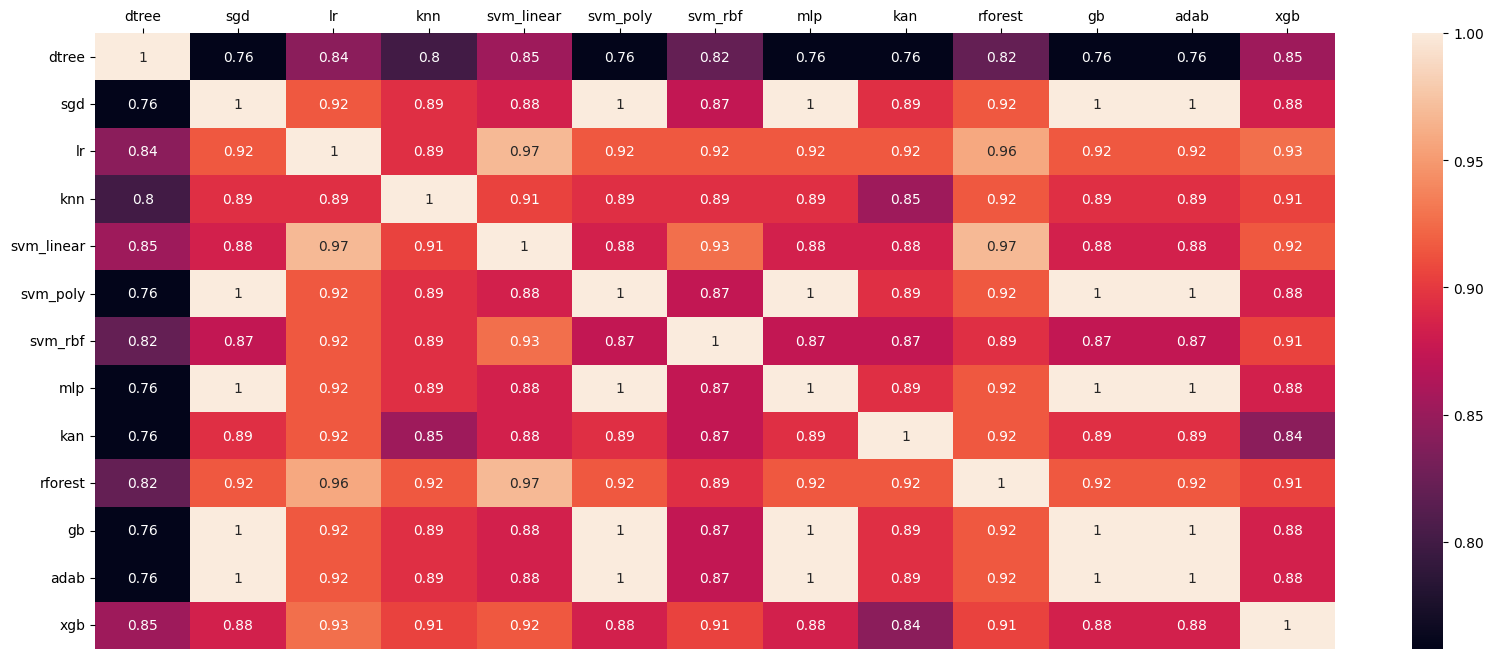

In [96]:
#y_pred = pd.DataFrame(columns=model_names)

indass_corrls = pd.DataFrame(columns=model_names, index=model_names, dtype=float)

for m in model_names:
    y_pred1 = pd.Series(1 - np.round(ind_assessors[m].predict(Xa_train)), index=Xa_train.index)
    for n in model_names:
        y_pred2 = pd.Series(1 - np.round(ind_assessors[n].predict(Xa_train)), index=Xa_train.index)
        indass_corrls.at[m,n] = np.mean((y_pred1==ya_train_tgt) == (y_pred2==ya_train_tgt))

plt.figure(figsize=(20,8))
hm = sns.heatmap(indass_corrls, annot=True)
hm.xaxis.tick_top()

In [97]:
indass_corrls_values = pd.Series(indass_corrls.values.reshape((169,)))
indass_corrls_values.describe()

count    169.000000
mean       0.904578
std        0.064133
min        0.757895
25%        0.884211
50%        0.894737
75%        0.926316
max        1.000000
dtype: float64

In [98]:
min_score5 = indass_corrls_values.quantile(0.75)

print('Min_score:', min_score5)

groups['indv_assessor_train'] = group_search(indass_corrls, min_score5)
groups['indv_assessor_train']

Min_score: 0.9263157894736842


[['dtree'],
 ['adab', 'gb', 'mlp', 'sgd', 'svm_poly'],
 ['lr', 'rforest', 'svm_linear'],
 ['lr', 'xgb'],
 ['knn'],
 ['svm_linear', 'svm_rbf'],
 ['kan']]

Conjunto de Teste:

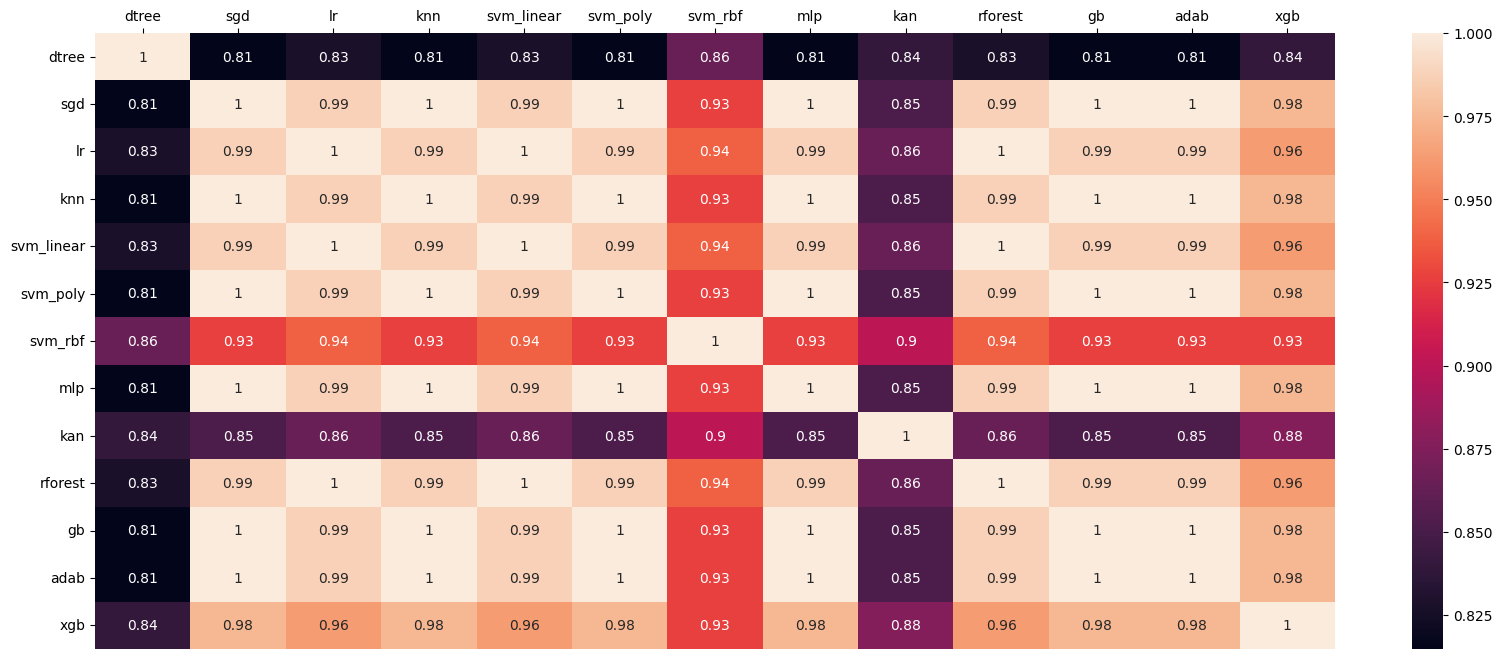

In [99]:
#y_pred = pd.DataFrame(columns=model_names)

indass_corrls = pd.DataFrame(columns=model_names, index=model_names, dtype=float)

for m in model_names:
    y_pred1 = pd.Series(1 - np.round(ind_assessors[m].predict(Xa_test)), index=Xa_test.index)
    for n in model_names:
        y_pred2 = pd.Series(1 - np.round(ind_assessors[n].predict(Xa_test)), index=Xa_test.index)
        indass_corrls.at[m,n] = np.mean((y_pred1==ya_test_tgt) == (y_pred2==ya_test_tgt))

plt.figure(figsize=(20,8))
hm = sns.heatmap(indass_corrls, annot=True)
hm.xaxis.tick_top()

In [100]:
indass_corrls_values = pd.Series(indass_corrls.values.reshape((169,)))
indass_corrls_values.describe()

count    169.000000
mean       0.943312
std        0.066024
min        0.814815
25%        0.876543
50%        0.987654
75%        1.000000
max        1.000000
dtype: float64

In [101]:
min_score5 = indass_corrls_values.quantile(0.75)

print('Min_score:', min_score5)

groups['indv_assessor_test'] = group_search(indass_corrls, min_score5)
groups['indv_assessor_test']

Min_score: 1.0


[['dtree'],
 ['adab', 'gb', 'knn', 'mlp', 'sgd', 'svm_poly'],
 ['lr', 'rforest', 'svm_linear'],
 ['svm_rbf'],
 ['kan'],
 ['xgb']]

## Análises

In [102]:
mse_df = mse_df.reset_index().melt(id_vars='index', var_name='Modelo', value_name='MSE')
mse_df = mse_df.rename(columns={'index': 'assessor_type'})

rmse_df = rmse_df.reset_index().melt(id_vars='index', var_name='Modelo', value_name='RMSE')
rmse_df = rmse_df.rename(columns={'index': 'assessor_type'})

mae_df = mae_df.reset_index().melt(id_vars='index', var_name='Modelo', value_name='MAE')
mae_df = mae_df.rename(columns={'index': 'assessor_type'})

nmse_df = nmse_df.reset_index().melt(id_vars='index', var_name='Modelo', value_name='NMSE')
nmse_df = nmse_df.rename(columns={'index': 'assessor_type'})
mse_df

,assessor_type,Modelo,MSE
0,regchain,dtree,0.070750
1,multi-output,dtree,0.070750
2,individual,dtree,0.067037
3,regchain,sgd,0.144675
4,multi-output,sgd,0.149822
5,individual,sgd,0.153973
6,regchain,lr,0.008020
7,multi-output,lr,0.008231
8,individual,lr,0.008214
9,regchain,knn,0.088693


In [103]:
class_palette = [sns.color_palette()[0], sns.color_palette()[3], sns.color_palette()[2]]

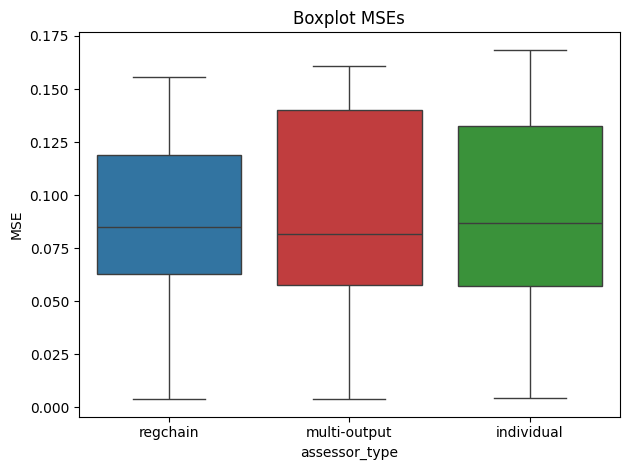

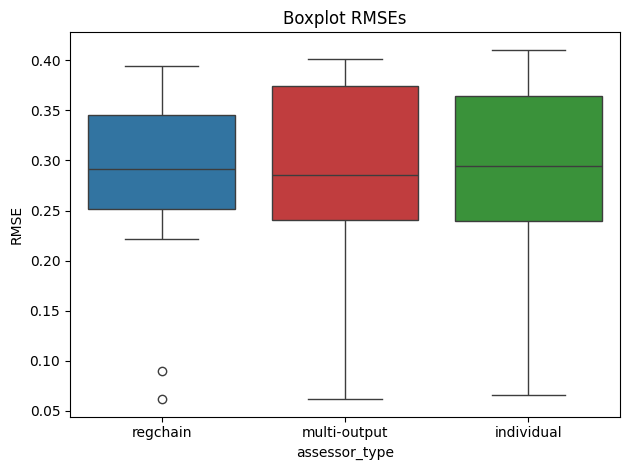

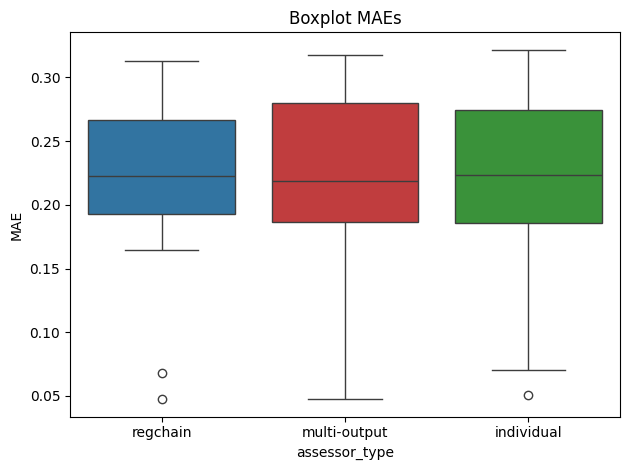

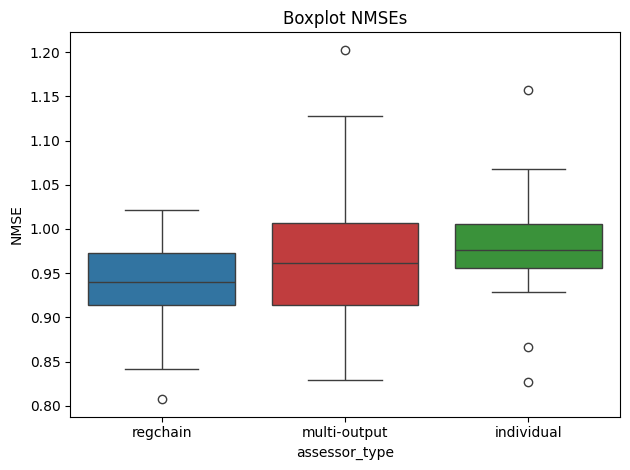

In [104]:
plt.title('Boxplot MSEs')
sns.boxplot(mse_df, y='MSE', x='assessor_type', hue='assessor_type', palette=class_palette)
plt.tight_layout()
plt.show()

plt.title('Boxplot RMSEs')
sns.boxplot(rmse_df, y='RMSE', x='assessor_type', hue='assessor_type', palette=class_palette)
plt.tight_layout()
plt.show()

plt.title('Boxplot MAEs')
sns.boxplot(mae_df, y='MAE', x='assessor_type', hue='assessor_type', palette=class_palette)
plt.tight_layout()
plt.show()

plt.title('Boxplot NMSEs')
sns.boxplot(nmse_df, y='NMSE', x='assessor_type', hue='assessor_type', palette=class_palette)
plt.tight_layout()
plt.show()

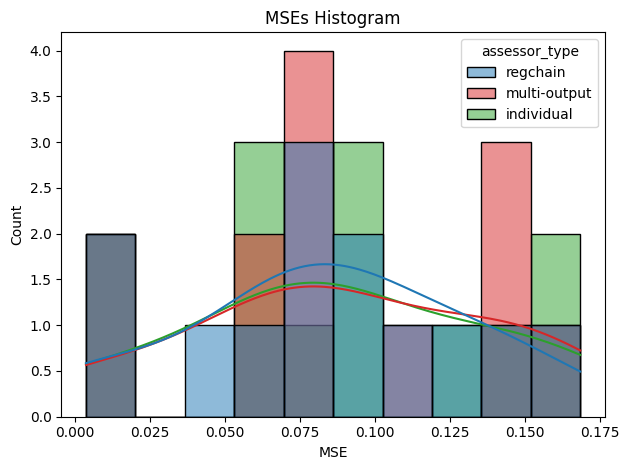

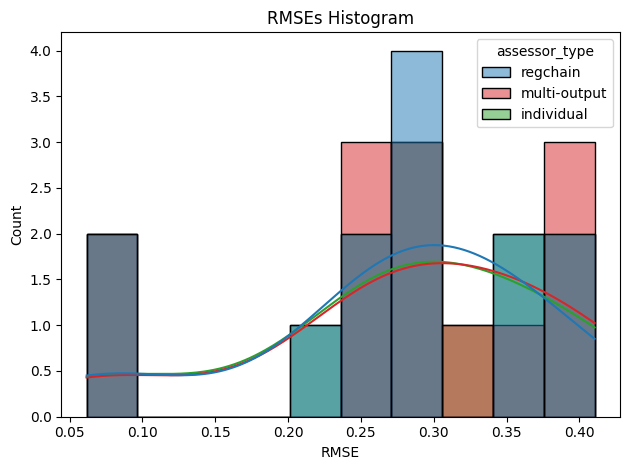

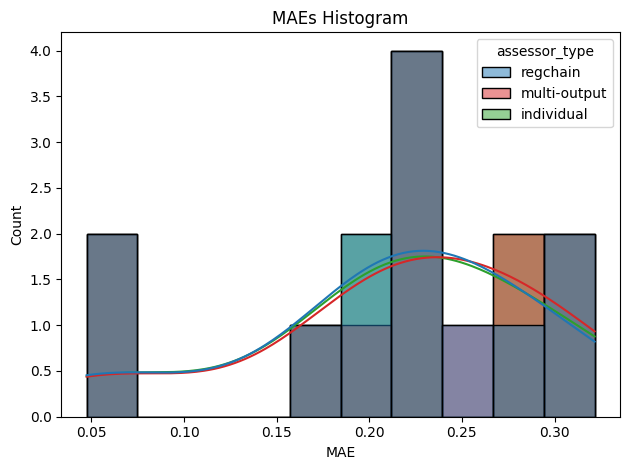

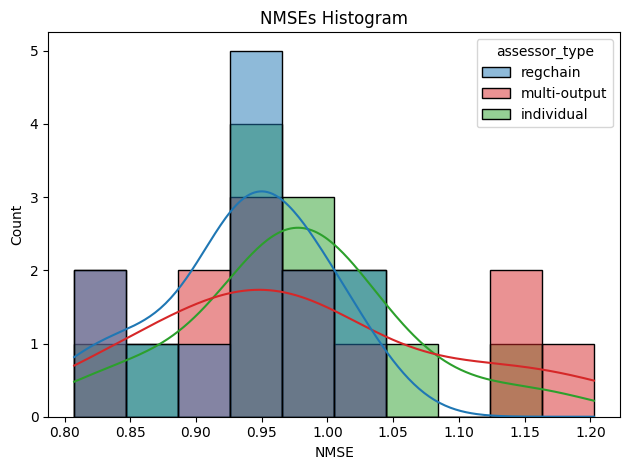

In [105]:
plt.title('MSEs Histogram')
sns.histplot(mse_df, x='MSE', hue='assessor_type', bins=10, multiple='layer', palette=class_palette, kde=True)
plt.tight_layout()
plt.show()

plt.title('RMSEs Histogram')
sns.histplot(rmse_df, x='RMSE', hue='assessor_type', bins=10, multiple='layer', palette=class_palette, kde=True)
plt.tight_layout()
plt.show()

plt.title('MAEs Histogram')
sns.histplot(mae_df, x='MAE', hue='assessor_type', bins=10, multiple='layer', palette=class_palette, kde=True)
plt.tight_layout()
plt.show()

plt.title('NMSEs Histogram')
sns.histplot(nmse_df, x='NMSE', hue='assessor_type', bins=10, multiple='layer', palette=class_palette, kde=True)
plt.tight_layout()
plt.show()

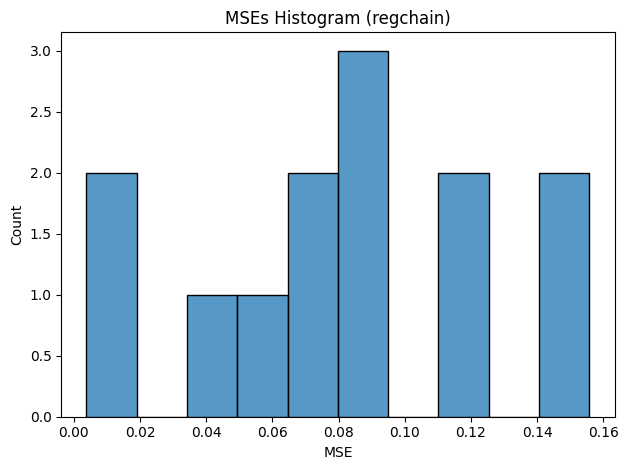

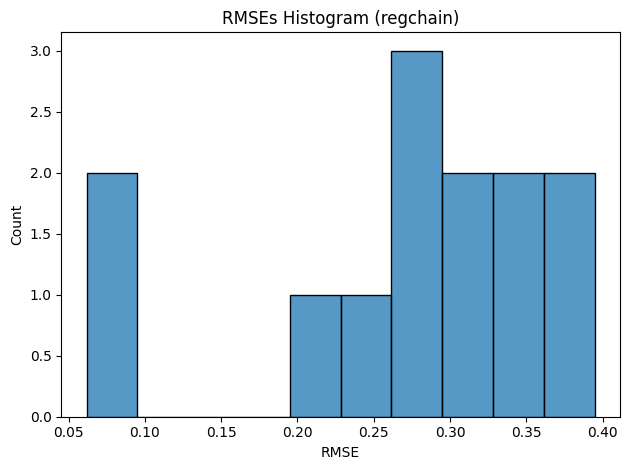

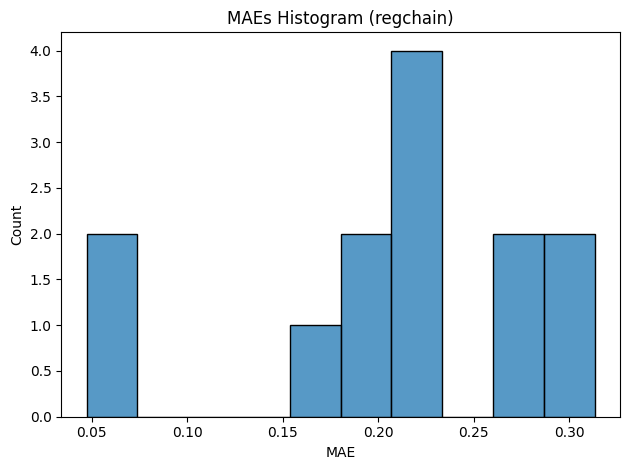

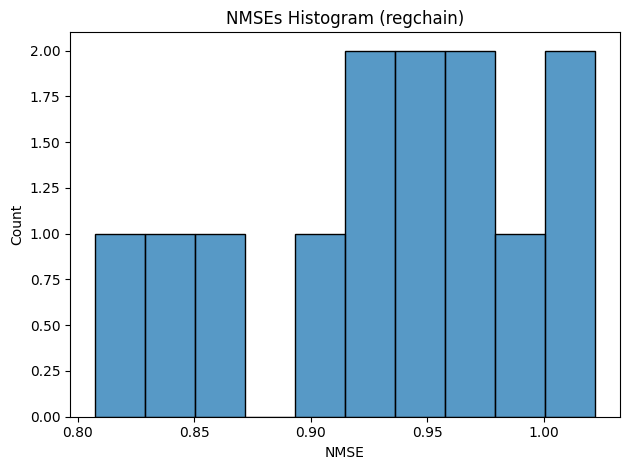

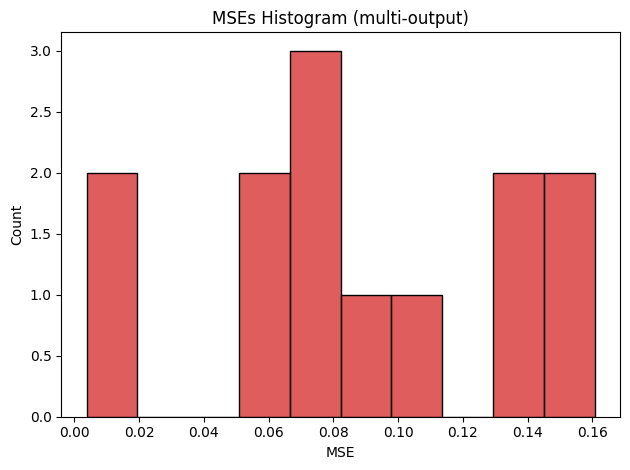

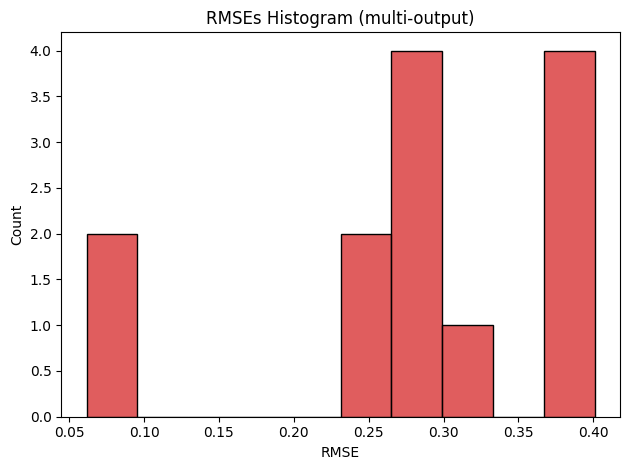

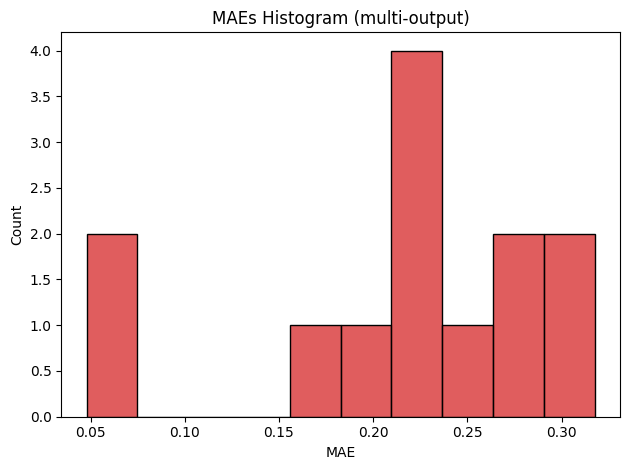

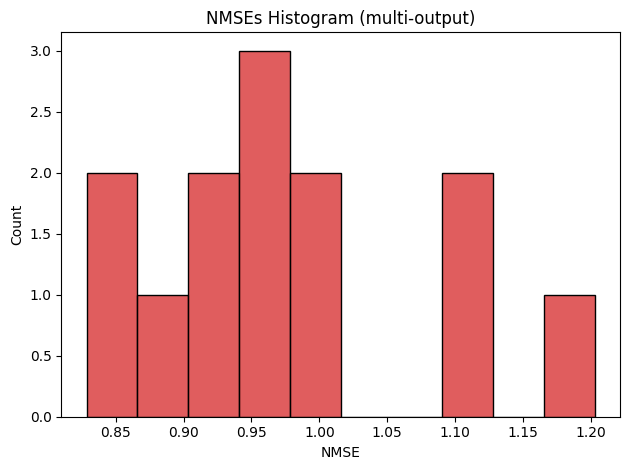

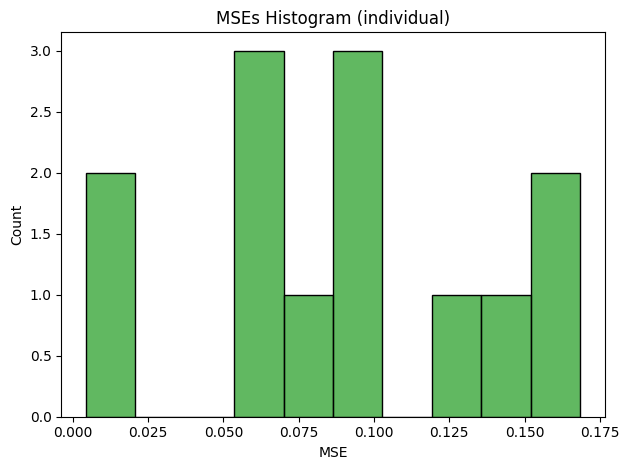

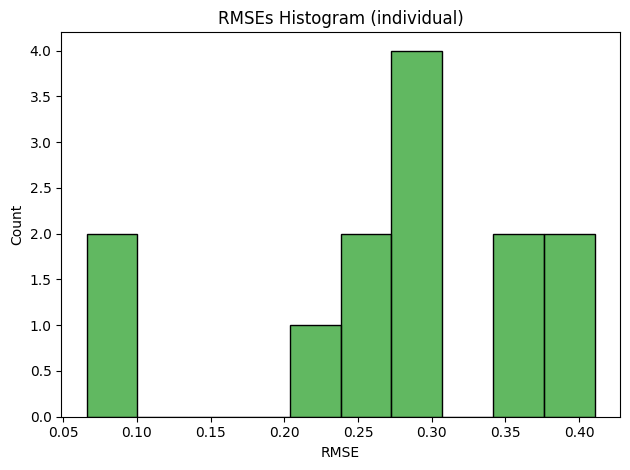

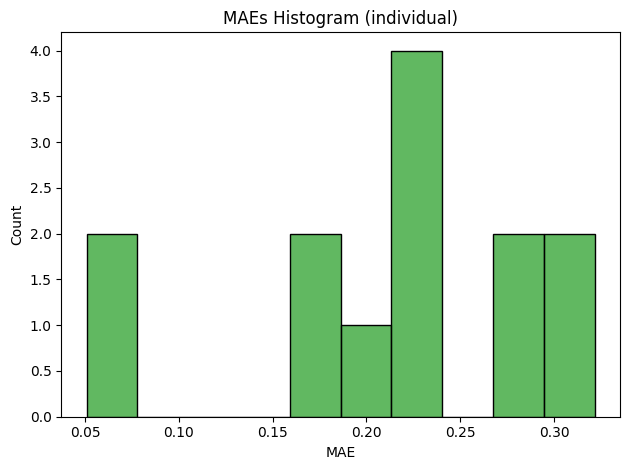

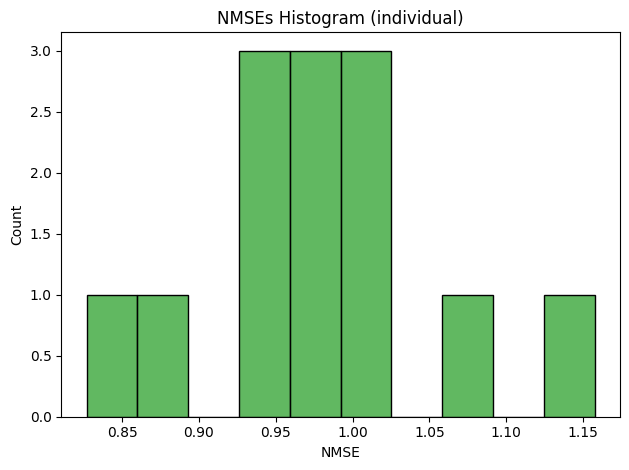

In [106]:
teste = {'regchain': class_palette[0], 'multi-output': class_palette[1], 'individual': class_palette[2]}

for a in ['regchain', 'multi-output', 'individual']:
    plt.title(f'MSEs Histogram ({a})')
    sns.histplot(mse_df[mse_df['assessor_type']==a], x='MSE', bins=10, color=teste[a])
    plt.tight_layout()
    plt.show()

    plt.title(f'RMSEs Histogram ({a})')
    sns.histplot(rmse_df[rmse_df['assessor_type']==a], x='RMSE', bins=10, color=teste[a])
    plt.tight_layout()
    plt.show()

    plt.title(f'MAEs Histogram ({a})')
    sns.histplot(mae_df[mae_df['assessor_type']==a], x='MAE', bins=10, color=teste[a])
    plt.tight_layout()
    plt.show()

    plt.title(f'NMSEs Histogram ({a})')
    sns.histplot(nmse_df[nmse_df['assessor_type']==a], x='NMSE', bins=10, color=teste[a])
    plt.tight_layout()
    plt.show()

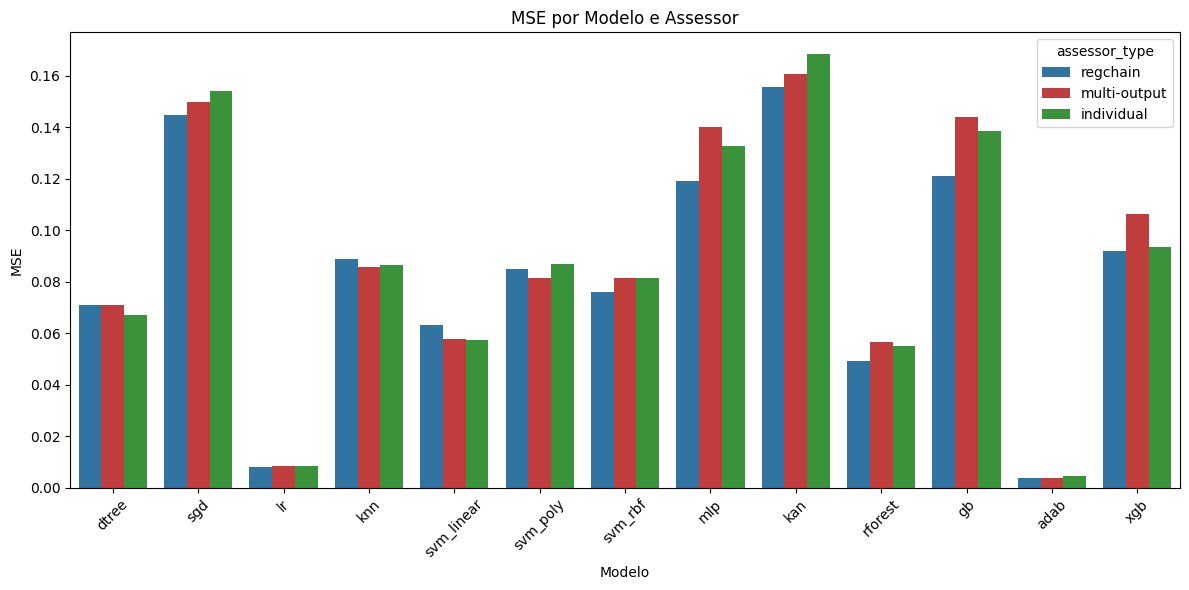

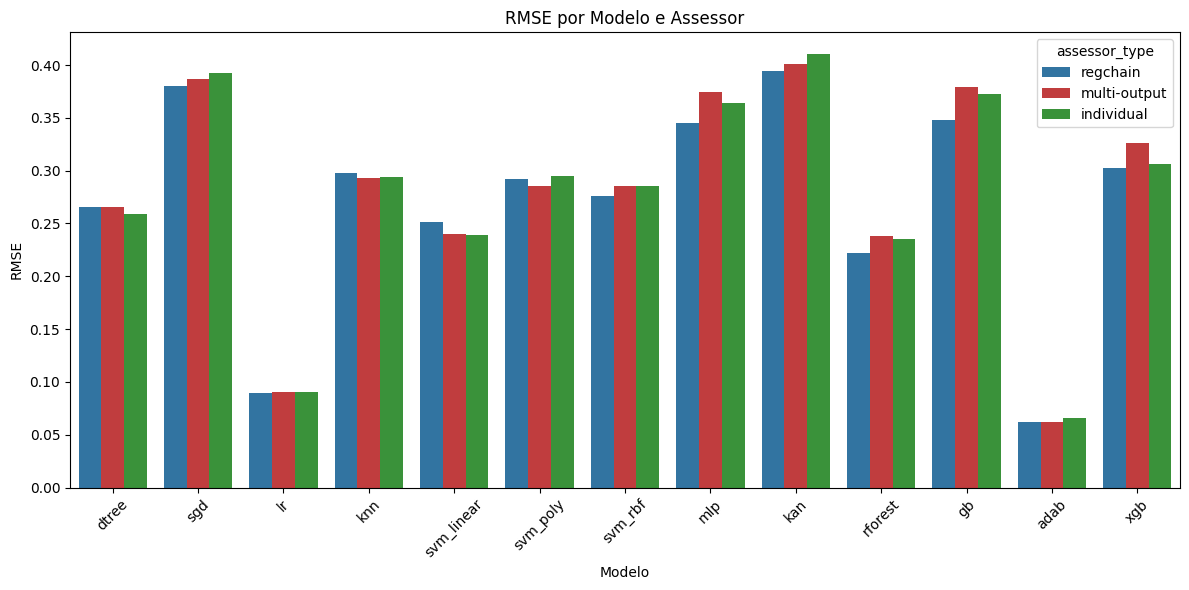

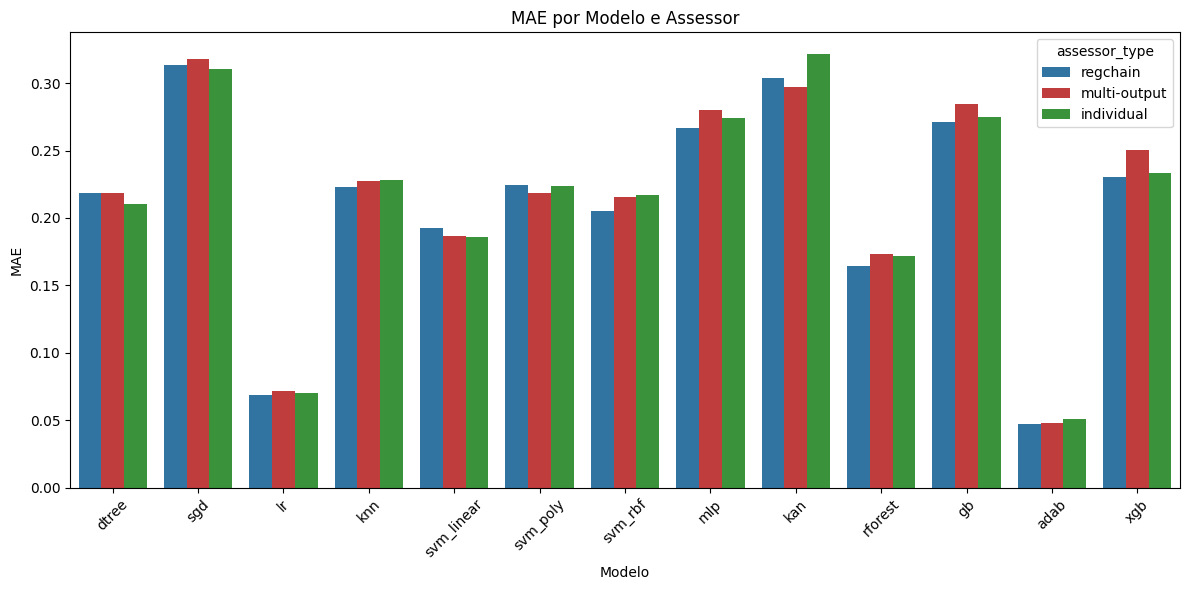

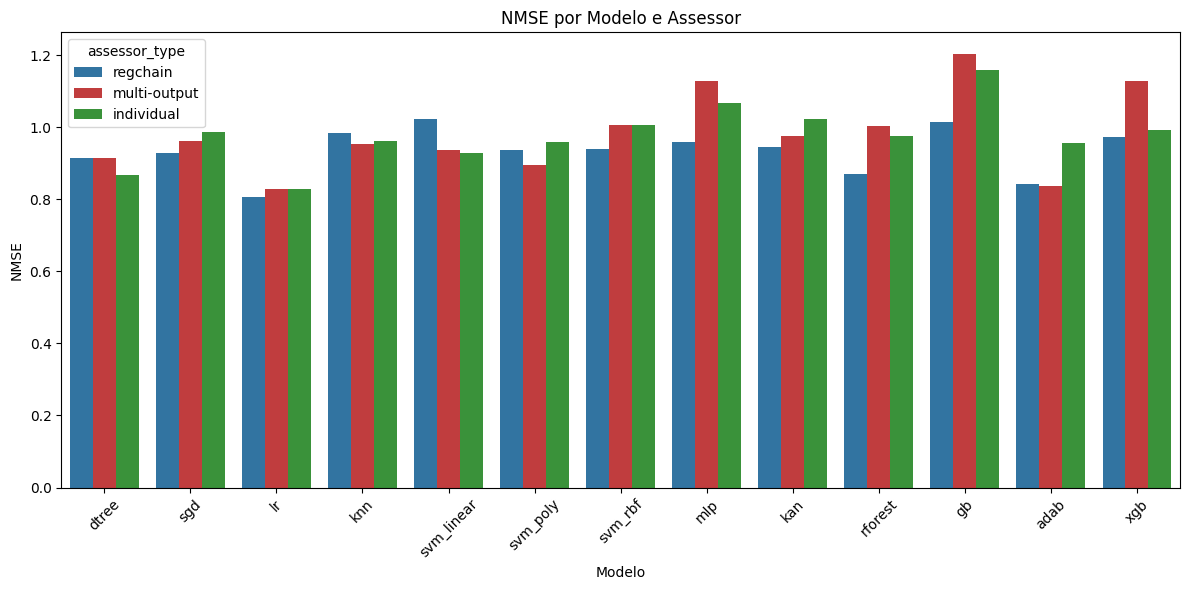

In [107]:
plt.figure(figsize=(12, 6))
sns.barplot(data=mse_df, x='Modelo', y='MSE', hue='assessor_type', palette=class_palette)
plt.title('MSE por Modelo e Assessor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=rmse_df, x='Modelo', y='RMSE', hue='assessor_type', palette=class_palette)
plt.title('RMSE por Modelo e Assessor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=mae_df, x='Modelo', y='MAE', hue='assessor_type', palette=class_palette)
plt.title('MAE por Modelo e Assessor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(data=nmse_df, x='Modelo', y='NMSE', hue='assessor_type', palette=class_palette)
plt.title('NMSE por Modelo e Assessor')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Grupais

In [108]:
keys = list(groups.keys())
for i in range(len(keys)):
    for j in range(i+1, len(keys)):
        print(f'{keys[i]}({len(groups[keys[i]])}) & {keys[j]}({len(groups[keys[j]])}):')
        count = 0
        for g in groups[keys[i]]:
            if(g in groups[keys[j]]):
                print(g)
                count += 1
        print(f'Número de grupos em comum: {count}\n\n')

true_assessor_train(9) & true_assessor_test(10):
['dtree']
['kan']
Número de grupos em comum: 2


true_assessor_train(9) & regchain_assessor_train(8):
['dtree']
['kan']
Número de grupos em comum: 2


true_assessor_train(9) & regchain_assessor_test(6):
['dtree']
['kan']
Número de grupos em comum: 2


true_assessor_train(9) & mor_assessor_train(11):
['dtree']
['gb', 'rforest', 'svm_poly', 'xgb']
['mlp']
['kan']
Número de grupos em comum: 4


true_assessor_train(9) & mor_assessor_test(7):
['dtree']
['mlp']
['kan']
Número de grupos em comum: 3


true_assessor_train(9) & indv_assessor_train(7):
['dtree']
['kan']
Número de grupos em comum: 2


true_assessor_train(9) & indv_assessor_test(6):
['dtree']
['kan']
Número de grupos em comum: 2


true_assessor_test(10) & regchain_assessor_train(8):
['dtree']
['kan']
Número de grupos em comum: 2


true_assessor_test(10) & regchain_assessor_test(6):
['dtree']
['kan']
Número de grupos em comum: 2


true_assessor_test(10) & mor_assessor_train(11):
['dtr

### Regressor Chain

In [109]:
regchain_group = RegressorChain(RandomForestRegressor(random_state=seed), verbose=True, random_state=seed, cv=5).fit(Xa_train, ya_train)

[Chain] .................. (1 of 13) Processing order 0, total=   0.1s
[Chain] .................. (2 of 13) Processing order 1, total=   0.1s
[Chain] .................. (3 of 13) Processing order 2, total=   0.1s
[Chain] .................. (4 of 13) Processing order 3, total=   0.1s
[Chain] .................. (5 of 13) Processing order 4, total=   0.1s
[Chain] .................. (6 of 13) Processing order 5, total=   0.1s
[Chain] .................. (7 of 13) Processing order 6, total=   0.1s
[Chain] .................. (8 of 13) Processing order 7, total=   0.1s
[Chain] .................. (9 of 13) Processing order 8, total=   0.1s
[Chain] ................. (10 of 13) Processing order 9, total=   0.1s
[Chain] ................ (11 of 13) Processing order 10, total=   0.1s
[Chain] ................ (12 of 13) Processing order 11, total=   0.1s
[Chain] ................ (13 of 13) Processing order 12, total=   0.1s


### Multi-Output Regressor

### Análises